# Heartbeat Sounds Classification using Machine Learning
DSI 13 Capstone Project: Classifying heartbeat anomalies from stethoscope audio
**Notebook 3a: Modeling - DWT + MFCC CNN**

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

## plot
import matplotlib.pyplot as plt
import seaborn as sns

## others
#from glob import glob
import itertools


# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers, regularizers
from keras.wrappers.scikit_learn import KerasClassifier 

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline

# 5 Modelling

## 5.1 Baseline Accuracy

The baseline accuracy in this multi-class, classificiation problem is **60.2%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [3]:
df_ab = pd.read_csv('../outputs/df_ab.csv')

### drop audio wav with duration < 1sec
df_ab = df_ab[df_ab['wav_duration']>1]
### merge noisy murmur too murmur, and merge noisy normal to normalb
df_ab['label'].replace({'murmur_noisymurmur':'murmur', 'normal_noisynormal':'normal'}, inplace = True)
### Get the percentage distribution of each category
round(df_ab.groupby('label')['filename'].count()/df_ab.shape[0]*100, 1)

label
artifact       6.9
extrahls       3.1
extrastole     7.9
murmur        21.9
normal        60.2
Name: filename, dtype: float64

# 5.2 Convolutional Neural Networks (CNN)

**2D Convolutional Neural Networks**

- Starting with a sequential model so we can build the model layer by layer.
- The model consists of **3 x convolutional + pooling layer**. 
- The input is the 20 mfccs with 130 frames. Each convolutional layer have different number of convolutional filters. Max pooling is used and **dropout** of 20% on the 2nd and 3rd convolutional layer is applied to reduce over-fitting.
- Then, **flatten** the layer before passing it to fully connected dense layer.
- It has **1 dense layer** with 128 neurons and 50% dropout is applied as well for better generalisation and reduce overfit on the training data.
- The final **output layer have 5 neurons**, which is the **5 categories** that would like the model to classify the heartbeat audio. The activiation for all the layers is 'relu' and 'softmax' at the final layer. **Softmax** makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

## 5.2.1 X_train (No Synthesize and Oversampling)

In [4]:
### Load preprocess data from notebook 2

%store -r X_train_0 
%store -r X_test 
%store -r y_train_0 
%store -r y_test 
%store -r le
%store -r class_weights_0

In [5]:
### Build CNN model
model = Sequential()

# add 1st convolutional layer
model.add(Conv2D(filters = 32, kernel_size = 5, activation = 'relu', padding = 'same',
                 input_shape = (X_train_0.shape[1], X_train_0.shape[2], X_train_0.shape[3])))
model.add(MaxPooling2D())

# add 2nd convolutional layer
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# add 3rd convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# flatten results so that it can pass to dense layer
model.add(Flatten())

# add dense layer with 128 neurons
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
# add final layer with 5 neurons(5 label)
model.add(Dense(len(le.classes_), activation = 'softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 130, 32)       832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 65, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 65, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 32, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 32, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 32, 128)        204928    
______________________________________

### Compile model

In [6]:
Ad = optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer= Ad, metrics = ['accuracy'])

### Fit model

In [8]:
history = model.fit(X_train_0, y_train_0, validation_data = (X_test, y_test),
                    epochs = 100, class_weight=class_weights_0, verbose = 2)


Train on 464 samples, validate on 117 samples
Epoch 1/100
 - 3s - loss: 1.3330 - accuracy: 0.5453 - val_loss: 1.1361 - val_accuracy: 0.5983
Epoch 2/100
 - 3s - loss: 1.1814 - accuracy: 0.5948 - val_loss: 1.1560 - val_accuracy: 0.5983
Epoch 3/100
 - 3s - loss: 1.1481 - accuracy: 0.6013 - val_loss: 1.1407 - val_accuracy: 0.5983
Epoch 4/100
 - 3s - loss: 1.1643 - accuracy: 0.6034 - val_loss: 1.1395 - val_accuracy: 0.5983
Epoch 5/100
 - 3s - loss: 1.1554 - accuracy: 0.6034 - val_loss: 1.1545 - val_accuracy: 0.5983
Epoch 6/100
 - 3s - loss: 1.1391 - accuracy: 0.6034 - val_loss: 1.1387 - val_accuracy: 0.5983
Epoch 7/100
 - 4s - loss: 1.1612 - accuracy: 0.6034 - val_loss: 1.1326 - val_accuracy: 0.5983
Epoch 8/100
 - 4s - loss: 1.1365 - accuracy: 0.6034 - val_loss: 1.1343 - val_accuracy: 0.5983
Epoch 9/100
 - 4s - loss: 1.1411 - accuracy: 0.6034 - val_loss: 1.1333 - val_accuracy: 0.5983
Epoch 10/100
 - 5s - loss: 1.1355 - accuracy: 0.6034 - val_loss: 1.1322 - val_accuracy: 0.5983
Epoch 11/100

Epoch 85/100
 - 5s - loss: 0.6911 - accuracy: 0.7198 - val_loss: 0.8277 - val_accuracy: 0.7265
Epoch 86/100
 - 4s - loss: 0.7171 - accuracy: 0.7263 - val_loss: 0.9181 - val_accuracy: 0.6410
Epoch 87/100
 - 4s - loss: 0.7558 - accuracy: 0.7047 - val_loss: 0.8116 - val_accuracy: 0.7607
Epoch 88/100
 - 4s - loss: 0.7284 - accuracy: 0.7112 - val_loss: 0.7905 - val_accuracy: 0.7778
Epoch 89/100
 - 4s - loss: 0.6873 - accuracy: 0.7134 - val_loss: 0.7951 - val_accuracy: 0.7949
Epoch 90/100
 - 4s - loss: 0.6791 - accuracy: 0.7328 - val_loss: 0.8013 - val_accuracy: 0.7778
Epoch 91/100
 - 4s - loss: 0.6976 - accuracy: 0.7284 - val_loss: 0.8259 - val_accuracy: 0.7607
Epoch 92/100
 - 4s - loss: 0.6949 - accuracy: 0.7306 - val_loss: 0.7858 - val_accuracy: 0.7949
Epoch 93/100
 - 6s - loss: 0.6777 - accuracy: 0.7284 - val_loss: 0.8074 - val_accuracy: 0.7949
Epoch 94/100
 - 5s - loss: 0.6539 - accuracy: 0.7500 - val_loss: 0.8038 - val_accuracy: 0.7607
Epoch 95/100
 - 5s - loss: 0.6686 - accuracy: 0.73

### Evaluate the Loss and Accuracy Score

In [9]:
### Define Loss and Accuracy plot function
def loss_acc_plot(historyname, epochs_num, title):
    fig, (ax1,ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(12,10));
    # Loss plot
    ax1.plot(historyname.history['loss'], 'r', label = 'Train Loss')
    ax1.plot(historyname.history['val_loss'], 'b', label = 'Test Loss')
    ax1.legend(loc =1)
    plt.xlabel('Epochs', fontsize = 14)
    plt.xticks(np.arange(0,epochs_num+1,10))
    ax1.set_ylabel('Crossentropy Loss', fontsize = 14)
    ax1.set_ylim(0,3)
    ax1.set_title(title +" "+ 'Loss Curve', fontsize = 18)
    
    # Accuracy plot
    ax2.plot(historyname.history['accuracy'], 'r', label = 'Train Accuracy')
    ax2.plot(historyname.history['val_accuracy'], 'b', label = 'Test Accuracy')
    ax2.legend(loc =2)
    ax2.set_ylabel('Accuracy', fontsize =14)
    ax2.set_ylim(0,1)
    ax2.set_title(title +" " +'Accuracy Curve', fontsize =18)
    

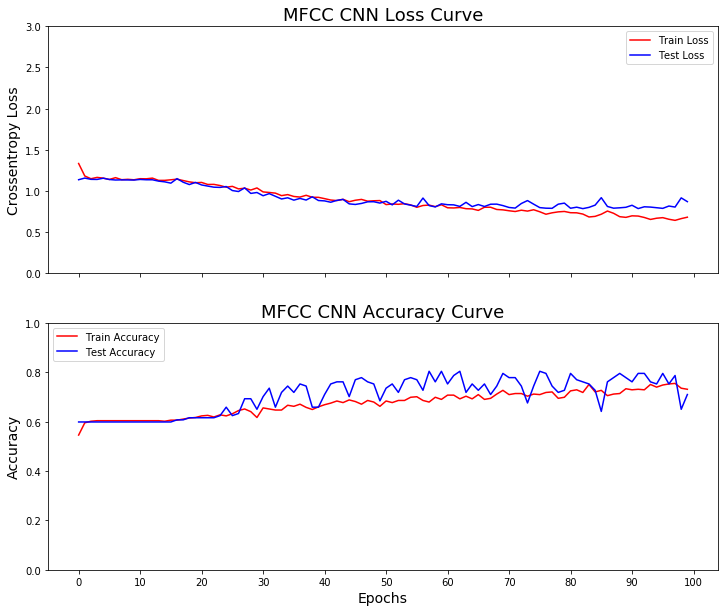

In [10]:
### Plot Loss & Accuracy curve
loss_acc_plot(history, 100, 'MFCC CNN')

In [11]:
### Function to print out the model's loss and accuracy score
def xtest_loss_acc(modelname, X_test, y_test):
    
    model_score = modelname.evaluate(X_test, y_test, verbose =2)
    model_labels = modelname.metrics_names
    
    print(f"cnn {model_labels[0]}: {round(model_score[0] ,3)}")
    print(f"cnn {model_labels[1]}: {round(model_score[1] ,3)}")

In [14]:
xtest_loss_acc(model, X_test, y_test)

cnn loss: 0.87
cnn accuracy: 0.709


### Model Prediction and evaluation on X_test

In [15]:
### Define function to predict X_test, return y_pred & y_true and print the classification report
def class_report(modelname, X_test, y_test, le):
    ### predict the X_test
    pred = modelname.predict_classes(X_test)
    
    # compile predicted results
    y_true, y_pred = [], []
    classes = le.classes_
    
    for idx, preds in enumerate(pred):
        y_true.append(classes[np.argmax(y_test[idx])])
        y_pred.append(classes[preds])
    
    print(classification_report(y_true, y_pred))
    return y_true, y_pred

### Model Evaluation

To evaluate the effectiveness of the classification model, metrics used to assess are:

1. **$Precision = TP/(FP+TP)$**

**Precision** provides the *positive predictive value, the proportion of samples that belong in category $x$ that are correctly placed in category $x$*. Example, among all predicted murmur heartbeat, how many did I predict correctly? High precision is with low FP (predict to be murmur but actually is not).

2. **$f1 = 2*(Precision*Recall)/(Precision + Recall)$**

**Weighted average for precision and recall**. This score takes both FN and FP into account as $Recall = TP/(FN+TP)$. This is better metric for evaluating an uneven class distribution problem, which is the case in this project. 

3. $Accuracy = (TP+TN)/(All predict)$

Model achieve **74%** accuracy.

The model able to classify well for normal, and murmur. However, it did badly on the two most minority category (extrahls and extrastole), where it classifying them all to be normal from normal category.

In [16]:
yt_1, yp_1 = class_report(model, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       0.78      0.88      0.82         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.50      0.11      0.18         9
      murmur       0.56      0.73      0.63        26
      normal       0.78      0.80      0.79        70

    accuracy                           0.71       117
   macro avg       0.52      0.50      0.49       117
weighted avg       0.68      0.71      0.68       117



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Category/ label that was wrongly classified by the model

In [17]:
### View the class with WRONG classificaiton 
cnn_pred_result = list(zip(yt_1, yp_1))
cnn_result_df = pd.DataFrame(cnn_pred_result, columns = ['label', 'pred_label'])
cnn_result_df[cnn_result_df['label'] != cnn_result_df['pred_label']]

,label,pred_label
0,normal,murmur
5,murmur,normal
7,extrastole,normal
8,artifact,murmur
12,extrahls,normal
14,normal,murmur
17,murmur,normal
18,normal,murmur
20,murmur,normal
22,extrahls,murmur


### Confusion Matrix

In [18]:
### Function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

    plt.show()

### Confusion Matrix

- The model predict most of the class to Normal category, which is the majority class/ category.

In [19]:
## Define function to get the confusion matrix and print out the plot as well

def conf_matrix(y_true, y_pred, le):
    cm = confusion_matrix(y_true, y_pred)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    
    classes = le.classes_
    print(cm)
    plot_confusion_matrix(cm_pct, classes)

[[ 7  0  0  1  0]
 [ 0  0  0  1  3]
 [ 0  0  1  1  7]
 [ 1  0  0 19  6]
 [ 1  0  1 12 56]]


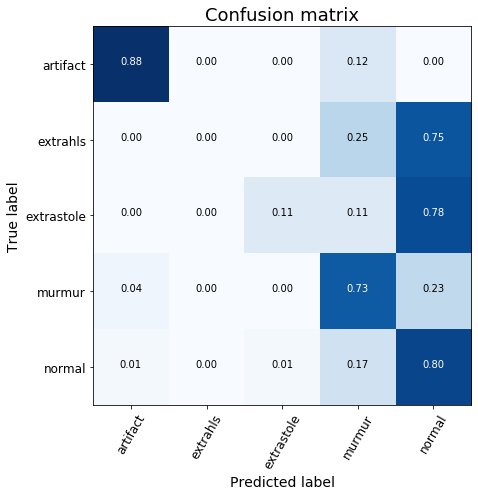

In [20]:
conf_matrix(yt_1, yp_1, le)

## 5.2.1.1 Hyperparameter Tuning with RandomSearchCV 
**X_train: No Synthesize and Oversampling**

In [21]:
### Set the hyperparameter for randomsearchCV

params = {
          'filter_one' : [16, 32], 'kernel_size_one' : [2,3,5],
          'filter_two' : [16,32,64], 'kernel_size_two' : [2,3,5], 'dropout_two': [0.2, 0.5],
          'filter_three' : [32, 64, 128], 'kernel_size_three' : [2,3,5], 'dropout_three': [0.2, 0.5],
          'neurons' : [64, 128, 256], 'dropout_four': [0.2, 0.5],
          'regularizer_rate' : [0.1, 0.05, 0.01],
           'opt_learning_rate' : [0.01, 0.001, 0.0001]
         }

In [24]:
### tentatively assign an input shape so that no error in the user define function below.
### MUST define input_shapes when apply the below function for RandomizedSearchCV
input_shapes = (X_train_0.shape[1], X_train_0.shape[2], X_train_0.shape[3])

In [26]:
### User defined model FUNCTION for RandomizedSearchCV
def model_funcs(
               filter_one = 16, kernel_size_one = 2, input_shapes=input_shapes,
               filter_two = 32, kernel_size_two = 2, dropout_two = 0.2,
               filter_three = 64, kernel_size_three = 2, dropout_three = 0.2,
               neurons = 128, dropout_four = 0.5,
               regularizer_rate = 0.1,
               opt_learning_rate = 0.0001):
    
    
    cnn = Sequential()
    
    # add 1st convolutional layer
    cnn.add(Conv2D(filters = filter_one, kernel_size = kernel_size_one, activation = 'relu', padding = 'same',
                  input_shape = input_shapes))
    cnn.add(MaxPooling2D())
    
    # add 2nd convolutional layer
    cnn.add(Conv2D(filters = filter_two, kernel_size = kernel_size_two, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_two))
    
    # add 3rd convolutional layer
    cnn.add(Conv2D(filters = filter_three, kernel_size = kernel_size_three, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_three))
    
    # flatten layer before passing to FC layer
    cnn.add(Flatten())
    
    # add densely connected layer
    cnn.add(Dense(neurons, activation = 'relu', kernel_regularizer = regularizers.l2(regularizer_rate)))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_four))
    
    # add output layer
    cnn.add(Dense(len(le.classes_), activation = 'softmax'))
    
    # add optimizer
    Ad = optimizers.Adam(learning_rate = opt_learning_rate)
    
    # compile model
    cnn.compile(loss = 'categorical_crossentropy', optimizer= Ad, metrics = ['accuracy'])

    return cnn

In [307]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_0.shape[1], X_train_0.shape[2], X_train_0.shape[3])

nn = KerasClassifier(build_fn = model_funcs, epochs = 50, verbose = 2)

### Instantiate RandomSearchCV
rscv = RandomizedSearchCV(nn, param_distributions = params, cv = 3)
rscv.fit(X_train_0, y_train_0)

# model best estimators
print(f"best estimator: {rscv.best_params_}")
print(f"best score: {rscv.best_score_}")

Epoch 1/50
 - 18s - loss: 4.6394 - accuracy: 0.3074
Epoch 2/50
 - 2s - loss: 4.8299 - accuracy: 0.4660
Epoch 3/50
 - 2s - loss: 4.1869 - accuracy: 0.5825
Epoch 4/50
 - 2s - loss: 3.5039 - accuracy: 0.5631
Epoch 5/50
 - 2s - loss: 2.8867 - accuracy: 0.5696
Epoch 6/50
 - 2s - loss: 2.4723 - accuracy: 0.5890
Epoch 7/50
 - 2s - loss: 2.1593 - accuracy: 0.6117
Epoch 8/50
 - 2s - loss: 1.9772 - accuracy: 0.6019
Epoch 9/50
 - 2s - loss: 1.9699 - accuracy: 0.5890
Epoch 10/50
 - 2s - loss: 1.9457 - accuracy: 0.6214
Epoch 11/50
 - 2s - loss: 1.9022 - accuracy: 0.6214
Epoch 12/50
 - 2s - loss: 1.9151 - accuracy: 0.6084
Epoch 13/50
 - 2s - loss: 1.8866 - accuracy: 0.5922
Epoch 14/50
 - 2s - loss: 1.8836 - accuracy: 0.6084
Epoch 15/50
 - 2s - loss: 1.8649 - accuracy: 0.6019
Epoch 16/50
 - 2s - loss: 1.8133 - accuracy: 0.6181
Epoch 17/50
 - 2s - loss: 1.8835 - accuracy: 0.5858
Epoch 18/50
 - 2s - loss: 1.8734 - accuracy: 0.6181
Epoch 19/50
 - 2s - loss: 1.8272 - accuracy: 0.6117
Epoch 20/50
 - 2s - 

Epoch 9/50
 - 3s - loss: 18.6365 - accuracy: 0.2362
Epoch 10/50
 - 3s - loss: 18.2577 - accuracy: 0.2330
Epoch 11/50
 - 2s - loss: 17.7859 - accuracy: 0.2816
Epoch 12/50
 - 2s - loss: 17.4070 - accuracy: 0.2330
Epoch 13/50
 - 3s - loss: 16.8806 - accuracy: 0.2589
Epoch 14/50
 - 2s - loss: 16.5048 - accuracy: 0.2977
Epoch 15/50
 - 2s - loss: 16.0720 - accuracy: 0.3172
Epoch 16/50
 - 2s - loss: 15.6531 - accuracy: 0.3657
Epoch 17/50
 - 3s - loss: 15.3384 - accuracy: 0.3592
Epoch 18/50
 - 3s - loss: 14.9568 - accuracy: 0.3560
Epoch 19/50
 - 2s - loss: 14.6575 - accuracy: 0.3463
Epoch 20/50
 - 3s - loss: 14.2986 - accuracy: 0.3722
Epoch 21/50
 - 3s - loss: 13.9848 - accuracy: 0.3851
Epoch 22/50
 - 3s - loss: 13.6765 - accuracy: 0.3916
Epoch 23/50
 - 3s - loss: 13.3659 - accuracy: 0.4628
Epoch 24/50
 - 3s - loss: 13.0189 - accuracy: 0.5016
Epoch 25/50
 - 2s - loss: 12.7013 - accuracy: 0.5307
Epoch 26/50
 - 2s - loss: 12.4287 - accuracy: 0.4984
Epoch 27/50
 - 3s - loss: 12.1519 - accuracy: 0

Epoch 15/50
 - 1s - loss: 17.7004 - accuracy: 0.2977
Epoch 16/50
 - 1s - loss: 17.1964 - accuracy: 0.3236
Epoch 17/50
 - 1s - loss: 16.6707 - accuracy: 0.3625
Epoch 18/50
 - 1s - loss: 16.1487 - accuracy: 0.4466
Epoch 19/50
 - 1s - loss: 15.6985 - accuracy: 0.3916
Epoch 20/50
 - 1s - loss: 15.1985 - accuracy: 0.4595
Epoch 21/50
 - 1s - loss: 14.7475 - accuracy: 0.4272
Epoch 22/50
 - 1s - loss: 14.2944 - accuracy: 0.4628
Epoch 23/50
 - 1s - loss: 13.8696 - accuracy: 0.4790
Epoch 24/50
 - 1s - loss: 13.4421 - accuracy: 0.5016
Epoch 25/50
 - 2s - loss: 13.0257 - accuracy: 0.4337
Epoch 26/50
 - 1s - loss: 12.5973 - accuracy: 0.4984
Epoch 27/50
 - 2s - loss: 12.2115 - accuracy: 0.5049
Epoch 28/50
 - 1s - loss: 11.8363 - accuracy: 0.5405
Epoch 29/50
 - 1s - loss: 11.4427 - accuracy: 0.5113
Epoch 30/50
 - 1s - loss: 11.1005 - accuracy: 0.4887
Epoch 31/50
 - 1s - loss: 10.7552 - accuracy: 0.5307
Epoch 32/50
 - 1s - loss: 10.4008 - accuracy: 0.5469
Epoch 33/50
 - 1s - loss: 10.0664 - accuracy: 

Epoch 22/50
 - 1s - loss: 1.1529 - accuracy: 0.6796
Epoch 23/50
 - 1s - loss: 1.1329 - accuracy: 0.6796
Epoch 24/50
 - 2s - loss: 1.0992 - accuracy: 0.6634
Epoch 25/50
 - 2s - loss: 1.0458 - accuracy: 0.6990
Epoch 26/50
 - 1s - loss: 1.0610 - accuracy: 0.6537
Epoch 27/50
 - 1s - loss: 1.0470 - accuracy: 0.6990
Epoch 28/50
 - 1s - loss: 1.0329 - accuracy: 0.6893
Epoch 29/50
 - 1s - loss: 1.0308 - accuracy: 0.6667
Epoch 30/50
 - 1s - loss: 1.0000 - accuracy: 0.6796
Epoch 31/50
 - 1s - loss: 0.9806 - accuracy: 0.7120
Epoch 32/50
 - 1s - loss: 1.0138 - accuracy: 0.6634
Epoch 33/50
 - 1s - loss: 0.9741 - accuracy: 0.6764
Epoch 34/50
 - 1s - loss: 1.0122 - accuracy: 0.6634
Epoch 35/50
 - 1s - loss: 0.9470 - accuracy: 0.6893
Epoch 36/50
 - 1s - loss: 0.9425 - accuracy: 0.7055
Epoch 37/50
 - 1s - loss: 0.9568 - accuracy: 0.6796
Epoch 38/50
 - 1s - loss: 0.9095 - accuracy: 0.7314
Epoch 39/50
 - 1s - loss: 0.9115 - accuracy: 0.7055
Epoch 40/50
 - 2s - loss: 0.9496 - accuracy: 0.6828
Epoch 41/50


Epoch 30/50
 - 2s - loss: 0.9850 - accuracy: 0.6926
Epoch 31/50
 - 2s - loss: 0.9691 - accuracy: 0.6699
Epoch 32/50
 - 2s - loss: 0.9446 - accuracy: 0.6990
Epoch 33/50
 - 2s - loss: 0.9024 - accuracy: 0.7023
Epoch 34/50
 - 2s - loss: 0.9273 - accuracy: 0.6764
Epoch 35/50
 - 2s - loss: 0.8920 - accuracy: 0.7184
Epoch 36/50
 - 2s - loss: 0.8769 - accuracy: 0.7055
Epoch 37/50
 - 2s - loss: 0.8700 - accuracy: 0.7023
Epoch 38/50
 - 2s - loss: 0.8780 - accuracy: 0.7152
Epoch 39/50
 - 2s - loss: 0.8788 - accuracy: 0.6990
Epoch 40/50
 - 2s - loss: 0.8936 - accuracy: 0.6796
Epoch 41/50
 - 2s - loss: 0.8873 - accuracy: 0.6990
Epoch 42/50
 - 2s - loss: 0.9013 - accuracy: 0.6796
Epoch 43/50
 - 2s - loss: 0.8988 - accuracy: 0.7023
Epoch 44/50
 - 2s - loss: 0.8626 - accuracy: 0.7120
Epoch 45/50
 - 2s - loss: 0.8981 - accuracy: 0.6861
Epoch 46/50
 - 2s - loss: 0.8165 - accuracy: 0.7476
Epoch 47/50
 - 2s - loss: 0.8600 - accuracy: 0.7184
Epoch 48/50
 - 2s - loss: 0.7919 - accuracy: 0.7346
Epoch 49/50


Epoch 38/50
 - 2s - loss: 1.0104 - accuracy: 0.6796
Epoch 39/50
 - 2s - loss: 0.9841 - accuracy: 0.7023
Epoch 40/50
 - 2s - loss: 0.9419 - accuracy: 0.7087
Epoch 41/50
 - 2s - loss: 0.9767 - accuracy: 0.6731
Epoch 42/50
 - 2s - loss: 0.9687 - accuracy: 0.7249
Epoch 43/50
 - 2s - loss: 0.9685 - accuracy: 0.6699
Epoch 44/50
 - 2s - loss: 0.9474 - accuracy: 0.6926
Epoch 45/50
 - 2s - loss: 0.9650 - accuracy: 0.7087
Epoch 46/50
 - 2s - loss: 0.9932 - accuracy: 0.7184
Epoch 47/50
 - 2s - loss: 0.9096 - accuracy: 0.7184
Epoch 48/50
 - 2s - loss: 0.9418 - accuracy: 0.7249
Epoch 49/50
 - 2s - loss: 0.9603 - accuracy: 0.6990
Epoch 50/50
 - 1s - loss: 0.9225 - accuracy: 0.7184
Epoch 1/50
 - 28s - loss: 20.7901 - accuracy: 0.2071
Epoch 2/50
 - 2s - loss: 16.2249 - accuracy: 0.3010
Epoch 3/50
 - 2s - loss: 12.7105 - accuracy: 0.3754
Epoch 4/50
 - 1s - loss: 9.9373 - accuracy: 0.5405
Epoch 5/50
 - 1s - loss: 7.9173 - accuracy: 0.6375
Epoch 6/50
 - 2s - loss: 6.3240 - accuracy: 0.6796
Epoch 7/50
 - 

Epoch 46/50
 - 2s - loss: 0.9515 - accuracy: 0.6958
Epoch 47/50
 - 2s - loss: 0.9833 - accuracy: 0.6958
Epoch 48/50
 - 2s - loss: 0.9123 - accuracy: 0.7314
Epoch 49/50
 - 2s - loss: 0.9383 - accuracy: 0.6958
Epoch 50/50
 - 2s - loss: 0.9161 - accuracy: 0.7282
Epoch 1/50
 - 23s - loss: 4.6048 - accuracy: 0.2395
Epoch 2/50
 - 2s - loss: 4.1180 - accuracy: 0.2783
Epoch 3/50
 - 1s - loss: 3.9744 - accuracy: 0.2718
Epoch 4/50
 - 1s - loss: 3.6360 - accuracy: 0.4078
Epoch 5/50
 - 1s - loss: 3.3972 - accuracy: 0.4757
Epoch 6/50
 - 2s - loss: 3.0981 - accuracy: 0.5307
Epoch 7/50
 - 1s - loss: 3.0175 - accuracy: 0.5243
Epoch 8/50
 - 1s - loss: 2.8925 - accuracy: 0.5340
Epoch 9/50
 - 2s - loss: 2.6366 - accuracy: 0.5922
Epoch 10/50
 - 2s - loss: 2.5058 - accuracy: 0.6375
Epoch 11/50
 - 2s - loss: 2.3657 - accuracy: 0.6828
Epoch 12/50
 - 2s - loss: 2.2373 - accuracy: 0.6699
Epoch 13/50
 - 2s - loss: 2.1672 - accuracy: 0.6667
Epoch 14/50
 - 2s - loss: 2.0632 - accuracy: 0.6667
Epoch 15/50
 - 2s - 

 - 2s - loss: 3.3779 - accuracy: 0.1974
Epoch 5/50
 - 2s - loss: 3.3265 - accuracy: 0.2298
Epoch 6/50
 - 2s - loss: 3.2889 - accuracy: 0.2265
Epoch 7/50
 - 2s - loss: 3.2580 - accuracy: 0.1909
Epoch 8/50
 - 2s - loss: 3.1688 - accuracy: 0.2201
Epoch 9/50
 - 1s - loss: 3.1548 - accuracy: 0.2362
Epoch 10/50
 - 1s - loss: 3.0819 - accuracy: 0.2427
Epoch 11/50
 - 1s - loss: 3.0198 - accuracy: 0.2492
Epoch 12/50
 - 1s - loss: 3.0977 - accuracy: 0.2233
Epoch 13/50
 - 1s - loss: 3.0297 - accuracy: 0.2168
Epoch 14/50
 - 2s - loss: 2.9804 - accuracy: 0.2686
Epoch 15/50
 - 2s - loss: 2.9360 - accuracy: 0.2589
Epoch 16/50
 - 2s - loss: 2.9378 - accuracy: 0.2913
Epoch 17/50
 - 1s - loss: 2.9414 - accuracy: 0.2460
Epoch 18/50
 - 1s - loss: 2.9438 - accuracy: 0.2460
Epoch 19/50
 - 1s - loss: 2.8900 - accuracy: 0.2557
Epoch 20/50
 - 1s - loss: 2.8529 - accuracy: 0.2686
Epoch 21/50
 - 1s - loss: 2.7115 - accuracy: 0.3398
Epoch 22/50
 - 2s - loss: 2.8509 - accuracy: 0.2427
Epoch 23/50
 - 2s - loss: 2.7

Epoch 13/50
 - 2s - loss: 2.4311 - accuracy: 0.6214
Epoch 14/50
 - 2s - loss: 2.4869 - accuracy: 0.6246
Epoch 15/50
 - 2s - loss: 2.4269 - accuracy: 0.6019
Epoch 16/50
 - 1s - loss: 2.4051 - accuracy: 0.6505
Epoch 17/50
 - 2s - loss: 2.3519 - accuracy: 0.6117
Epoch 18/50
 - 3s - loss: 2.2617 - accuracy: 0.6602
Epoch 19/50
 - 2s - loss: 2.1739 - accuracy: 0.6634
Epoch 20/50
 - 2s - loss: 2.1290 - accuracy: 0.6440
Epoch 21/50
 - 2s - loss: 2.1784 - accuracy: 0.6731
Epoch 22/50
 - 2s - loss: 2.1201 - accuracy: 0.6634
Epoch 23/50
 - 2s - loss: 2.0300 - accuracy: 0.6537
Epoch 24/50
 - 1s - loss: 1.9763 - accuracy: 0.6537
Epoch 25/50
 - 2s - loss: 2.1082 - accuracy: 0.6246
Epoch 26/50
 - 2s - loss: 2.1810 - accuracy: 0.6602
Epoch 27/50
 - 2s - loss: 2.2051 - accuracy: 0.6440
Epoch 28/50
 - 2s - loss: 2.2281 - accuracy: 0.6861
Epoch 29/50
 - 2s - loss: 2.2965 - accuracy: 0.6602
Epoch 30/50
 - 2s - loss: 2.3425 - accuracy: 0.6278
Epoch 31/50
 - 2s - loss: 2.2584 - accuracy: 0.6731
Epoch 32/50


Epoch 21/50
 - 1s - loss: 1.2408 - accuracy: 0.6667
Epoch 22/50
 - 1s - loss: 1.1861 - accuracy: 0.6828
Epoch 23/50
 - 1s - loss: 1.1585 - accuracy: 0.6731
Epoch 24/50
 - 1s - loss: 1.1323 - accuracy: 0.6861
Epoch 25/50
 - 1s - loss: 1.1591 - accuracy: 0.6926
Epoch 26/50
 - 1s - loss: 1.1409 - accuracy: 0.6828
Epoch 27/50
 - 1s - loss: 1.1142 - accuracy: 0.6893
Epoch 28/50
 - 1s - loss: 1.1351 - accuracy: 0.6764
Epoch 29/50
 - 1s - loss: 1.0928 - accuracy: 0.6958
Epoch 30/50
 - 1s - loss: 1.1067 - accuracy: 0.6958
Epoch 31/50
 - 1s - loss: 1.1334 - accuracy: 0.6861
Epoch 32/50
 - 1s - loss: 1.1023 - accuracy: 0.6893
Epoch 33/50
 - 1s - loss: 1.0871 - accuracy: 0.6958
Epoch 34/50
 - 1s - loss: 1.1054 - accuracy: 0.6796
Epoch 35/50
 - 1s - loss: 1.0816 - accuracy: 0.7087
Epoch 36/50
 - 1s - loss: 1.1135 - accuracy: 0.7087
Epoch 37/50
 - 1s - loss: 1.0856 - accuracy: 0.6926
Epoch 38/50
 - 2s - loss: 1.0768 - accuracy: 0.6926
Epoch 39/50
 - 2s - loss: 1.0800 - accuracy: 0.6990
Epoch 40/50


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/50
 - 21s - loss: 20.2392 - accuracy: 0.2263
Epoch 2/50
 - 2s - loss: 15.4035 - accuracy: 0.2651
Epoch 3/50
 - 2s - loss: 11.6798 - accuracy: 0.3168
Epoch 4/50
 - 2s - loss: 8.9089 - accuracy: 0.4052
Epoch 5/50
 - 2s - loss: 6.9434 - accuracy: 0.4784
Epoch 6/50
 - 2s - loss: 5.4153 - accuracy: 0.6056
Epoch 7/50
 - 2s - loss: 4.3515 - accuracy: 0.6228
Epoch 8/50
 - 2s - loss: 3.6116 - accuracy: 0.6422
Epoch 9/50
 - 2s - loss: 3.0348 - accuracy: 0.6336
Epoch 10/50
 - 2s - loss: 2.5795 - accuracy: 0.6789
Epoch 11/50
 - 2s - loss: 2.2666 - accuracy: 0.6573
Epoch 12/50
 - 2s - loss: 2.0145 - accuracy: 0.6552
Epoch 13/50
 - 2s - loss: 1.8463 - accuracy: 0.6422
Epoch 14/50
 - 2s - loss: 1.6431 - accuracy: 0.6897
Epoch 15/50
 - 2s - loss: 1.5613 - accuracy: 0.6422
Epoch 16/50
 - 2s - loss: 1.4545 - accuracy: 0.6466
Epoch 17/50
 - 2s - loss: 1.3231 - accuracy: 0.6853
Epoch 18/50
 - 2s - loss: 1.2665 - accuracy: 0.6659
Epoch 19/50
 - 2s - loss: 1.2086 - accuracy: 0.6746
Epoch 20/50
 - 2s

In [313]:
### RandomizedSearchCV results

print(f" train score: {round(rscv.best_score_, 4)}")
print(f" test score: {round(rscv.score(X_test, y_test), 4)}")
print(f" best_parameters: {rscv.best_params_}")

 train score: 0.6552
 test score: 0.7094
 best_parameters: {'regularizer_rate': 0.05, 'opt_learning_rate': 0.001, 'neurons': 256, 'kernel_size_two': 3, 'kernel_size_three': 5, 'kernel_size_one': 3, 'filter_two': 32, 'filter_three': 32, 'filter_one': 16, 'dropout_two': 0.2, 'dropout_three': 0.2, 'dropout_four': 0.5}


## 5.2.1.2 CNN with Optimal Hyperparameter
**X_train: No Synthesize and Oversampling**

In [27]:
# Define fuction to build model

def cnn_model(filter_one, kernel_size_one, input_shapes,
                filter_two, kernel_size_two, dropout_two,
                filter_three, kernel_size_three, dropout_three,
                neurons, dropout_four, regularizer_rate,
                opt_learning_rate):
    
    cnn = Sequential()
    
    # add 1st convolutional layer
    cnn.add(Conv2D(filters = filter_one, kernel_size =kernel_size_one, activation = 'relu',
                   padding = 'same', input_shape = input_shapes ))
    cnn.add(MaxPooling2D())
    
    # 2nd convolutional layer
    cnn.add(Conv2D(filters =  filter_two, kernel_size = kernel_size_two, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_two))
    
    # 3rd convolutional layer
    cnn.add(Conv2D(filters =  filter_three, kernel_size = kernel_size_three, padding = 'same', activation = 'relu'))
    cnn.add(MaxPooling2D())
    cnn.add(Dropout(dropout_three))
    
    # flatten results so that it can pass to FC layer
    cnn.add(Flatten())
    
    # 1st Fully Connected (dense) layer
    cnn.add(Dense(neurons, activation = 'relu', kernel_regularizer=regularizers.l2(regularizer_rate)))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(dropout_four))
    
    # add final layer with 5 neurons(5 label)
    cnn.add(Dense(5, activation = 'softmax'))
    cnn.summary()
    
    ### Compile model
    Ad = optimizers.Adam(learning_rate=opt_learning_rate)
    cnn.compile(loss = 'categorical_crossentropy', optimizer = Ad, metrics = ['accuracy'])
    
    return cnn

In [28]:
### Fit model
model2 = cnn_model(16, 3,(X_train_0.shape[1], X_train_0.shape[2], X_train_0.shape[3]) ,
                32, 3, 0.2,
                32, 5, 0.2,
                256, 0.5, 0.05,
                0.001)
    
history2 = model2.fit(X_train_0, y_train_0, validation_data = (X_test, y_test),
                     epochs = 100, class_weight=class_weights_0, shuffle = True, verbose =2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 130, 16)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 65, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 65, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 32, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 32, 32)         25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 16, 32)        

Epoch 65/100
 - 1s - loss: 0.7373 - accuracy: 0.7543 - val_loss: 1.0109 - val_accuracy: 0.7265
Epoch 66/100
 - 1s - loss: 0.6719 - accuracy: 0.8147 - val_loss: 0.9004 - val_accuracy: 0.7607
Epoch 67/100
 - 1s - loss: 0.7039 - accuracy: 0.7845 - val_loss: 1.0115 - val_accuracy: 0.6581
Epoch 68/100
 - 1s - loss: 0.6766 - accuracy: 0.7974 - val_loss: 1.1021 - val_accuracy: 0.6838
Epoch 69/100
 - 1s - loss: 0.6604 - accuracy: 0.8125 - val_loss: 1.0810 - val_accuracy: 0.7436
Epoch 70/100
 - 1s - loss: 0.6747 - accuracy: 0.8168 - val_loss: 1.1317 - val_accuracy: 0.6325
Epoch 71/100
 - 1s - loss: 0.7164 - accuracy: 0.7716 - val_loss: 1.0036 - val_accuracy: 0.7350
Epoch 72/100
 - 1s - loss: 0.6727 - accuracy: 0.8125 - val_loss: 1.0934 - val_accuracy: 0.7265
Epoch 73/100
 - 1s - loss: 0.6818 - accuracy: 0.8254 - val_loss: 1.1537 - val_accuracy: 0.6923
Epoch 74/100
 - 1s - loss: 0.7119 - accuracy: 0.7974 - val_loss: 0.9387 - val_accuracy: 0.7692
Epoch 75/100
 - 1s - loss: 0.6608 - accuracy: 0.82

### Evaluate Loss and Accuracy Score 
**X_train: No Synthesize and Oversampling**

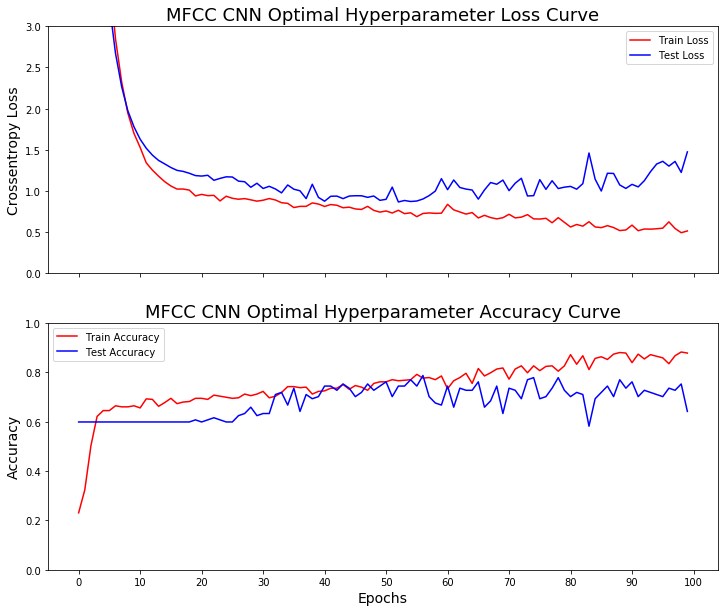

In [29]:
loss_acc_plot(history2, 100, 'MFCC CNN Optimal Hyperparameter')

In [30]:
### X_test loss and accuracy score

xtest_loss_acc(model2, X_test, y_test)

cnn loss: 1.474
cnn accuracy: 0.641


### Prediction and Model Evaluation

Model with optimized hyperparameter resulted in:
- `Normal`, precision = 71% (slightly lower than model1 = 78%).
- `Murmur`, precision = 75% (better than model1 = 56%).
- `extrahls`, `extrastole` precision = 0%, 9% (model1 = 0%, 50%)
- `Artifact`, precision 70% (model1 = 78%).

In general, imbalanced dataset without treatment does not perform good, particularly not able to classify the minority class well.

In [31]:
yt_2,yp_2 = class_report(model2, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       0.70      0.88      0.78         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.09      0.11      0.10         9
      murmur       0.75      0.46      0.57        26
      normal       0.71      0.79      0.74        70

    accuracy                           0.64       117
   macro avg       0.45      0.45      0.44       117
weighted avg       0.64      0.64      0.63       117



### Confusion Matrix

[[ 7  0  0  1  0]
 [ 0  0  1  0  3]
 [ 0  0  1  0  8]
 [ 1  1  0 12 12]
 [ 2  1  9  3 55]]


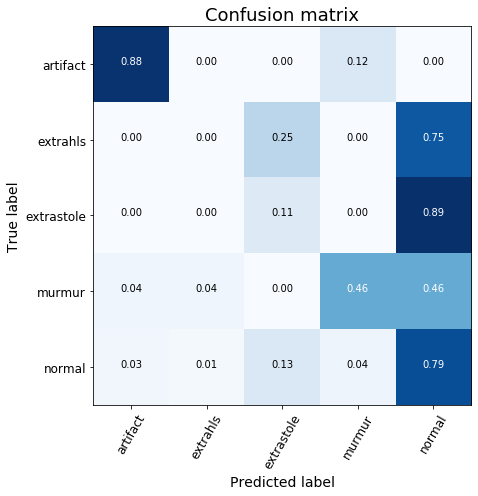

In [32]:
conf_matrix(yt_2, yp_2, le)

## 5.2.2 X_train (Increase minority class with Synthesize audio)

In [33]:
### load the pre-processing data (data + synthesize minority category audio)
%store -r X_train_1
%store -r X_test 
%store -r y_train_1 
%store -r y_test 
%store -r le
%store -r class_weights_1

### CNN using Optimal Hyperparameter obtain from previous section

In [34]:
### Build and Fit model
model3 = cnn_model(16, 2,(X_train_1.shape[1], X_train_1.shape[2], X_train_1.shape[3]) ,
                32, 3, 0.2,
                32, 5, 0.2,
                64, 0.2, 0.1,
                0.001)
    
history3 = model3.fit(X_train_1, y_train_1, validation_data = (X_test, y_test),
                     epochs = 100, class_weight=class_weights_1, shuffle = True, verbose =2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 130, 16)       80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 65, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 65, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 32, 32)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 32, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 32, 32)         25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 2, 16, 32)        

 - 2s - loss: 0.7321 - accuracy: 0.7619 - val_loss: 1.1680 - val_accuracy: 0.5470
Epoch 66/100
 - 2s - loss: 0.7035 - accuracy: 0.7531 - val_loss: 1.0989 - val_accuracy: 0.6838
Epoch 67/100
 - 2s - loss: 0.7144 - accuracy: 0.7725 - val_loss: 1.0781 - val_accuracy: 0.7350
Epoch 68/100
 - 2s - loss: 0.7390 - accuracy: 0.7637 - val_loss: 1.0862 - val_accuracy: 0.6838
Epoch 69/100
 - 1s - loss: 0.7567 - accuracy: 0.7654 - val_loss: 0.9487 - val_accuracy: 0.7350
Epoch 70/100
 - 2s - loss: 0.7104 - accuracy: 0.7743 - val_loss: 1.1153 - val_accuracy: 0.6496
Epoch 71/100
 - 2s - loss: 0.6948 - accuracy: 0.7619 - val_loss: 1.1201 - val_accuracy: 0.6239
Epoch 72/100
 - 2s - loss: 0.6918 - accuracy: 0.7795 - val_loss: 1.1695 - val_accuracy: 0.6068
Epoch 73/100
 - 2s - loss: 0.7256 - accuracy: 0.7690 - val_loss: 1.1066 - val_accuracy: 0.6581
Epoch 74/100
 - 1s - loss: 0.7032 - accuracy: 0.7901 - val_loss: 1.1790 - val_accuracy: 0.7265
Epoch 75/100
 - 1s - loss: 0.7077 - accuracy: 0.7743 - val_loss

### Evaluate Loss and Accuracy Score 
**X_train: Synthesize minority category**

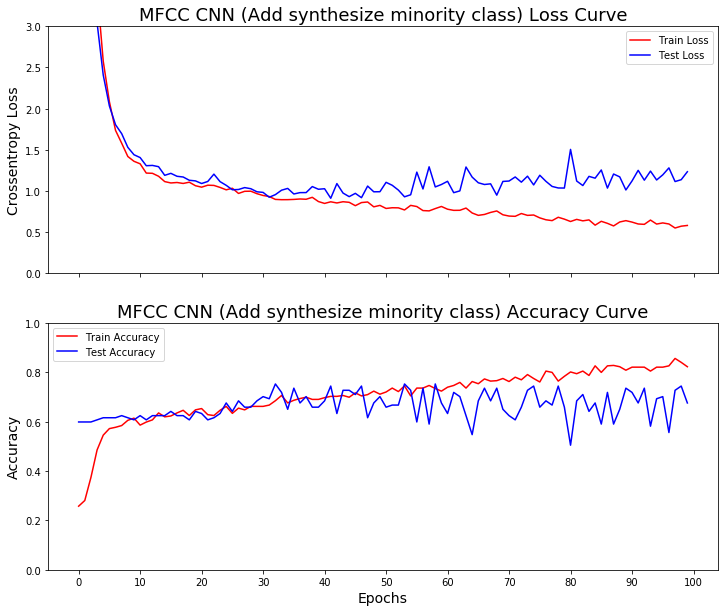

In [35]:
loss_acc_plot(history3, 100, 'MFCC CNN (Add synthesize minority class)')

In [36]:
### X_test loss and accuracy score

xtest_loss_acc(model3, X_test, y_test)

cnn loss: 1.233
cnn accuracy: 0.675


### Prediction and Model Evaluation

Model with imbalanced class treatment (synthesize audio) resulted in:
- `Normal`, precision = 75% (model2 = 71%).
- `Murmur`, precision = 60% (model2 = 75%).
- `extrahls`, `extrastole` precision = 0% & 14% respectively (model2 = 0% & 9%)
- `Artifact`, precision 78% (worst than model2 = 70%).


In [37]:
yt_3,yp_3 = class_report(model3, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       0.78      0.88      0.82         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.14      0.11      0.12         9
      murmur       0.60      0.69      0.64        26
      normal       0.75      0.76      0.75        70

    accuracy                           0.68       117
   macro avg       0.45      0.49      0.47       117
weighted avg       0.64      0.68      0.66       117



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion Matrix

[[ 7  0  0  1  0]
 [ 0  0  0  1  3]
 [ 0  0  1  0  8]
 [ 1  0  0 18  7]
 [ 1  0  6 10 53]]


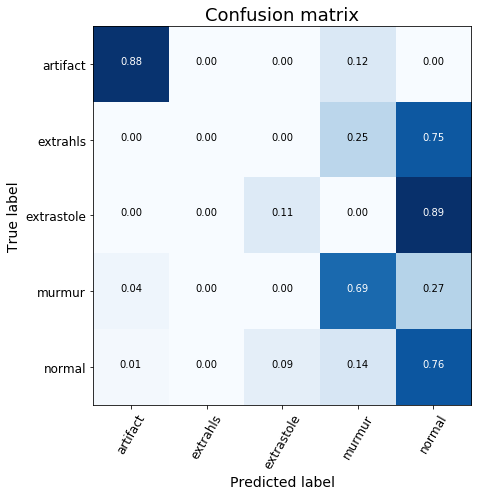

In [38]:
conf_matrix(yt_3, yp_3, le)

## 5.2.2.1 Hyperparameter Tuning with RandomSearchCV 
**X_train: with Synthesize minority category**

In [274]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train_1.shape[1], X_train_1.shape[2], X_train_1.shape[3])

nn = KerasClassifier(build_fn = model_funcs, epochs = 50, verbose = 2)

### Instantiate RandomSearchCV
rscv2 = RandomizedSearchCV(nn, param_distributions = params, cv = 3)
rscv2.fit(X_train_1, y_train_1)

# model best estimators
print(f"best estimator: {rscv2.best_params_}")
print(f"best score: {rscv2.best_score_}")

Epoch 1/50
 - 11s - loss: 14.4824 - accuracy: 0.2287
Epoch 2/50
 - 2s - loss: 14.0952 - accuracy: 0.2314
Epoch 3/50
 - 2s - loss: 13.8970 - accuracy: 0.1809
Epoch 4/50
 - 1s - loss: 13.4689 - accuracy: 0.2048
Epoch 5/50
 - 1s - loss: 13.2090 - accuracy: 0.2128
Epoch 6/50
 - 1s - loss: 12.8822 - accuracy: 0.2207
Epoch 7/50
 - 1s - loss: 12.5984 - accuracy: 0.2234
Epoch 8/50
 - 1s - loss: 12.2109 - accuracy: 0.2527
Epoch 9/50
 - 1s - loss: 11.9600 - accuracy: 0.2447
Epoch 10/50
 - 1s - loss: 11.8010 - accuracy: 0.2314
Epoch 11/50
 - 1s - loss: 11.3721 - accuracy: 0.2527
Epoch 12/50
 - 1s - loss: 11.1611 - accuracy: 0.2739
Epoch 13/50
 - 1s - loss: 10.9508 - accuracy: 0.2553
Epoch 14/50
 - 1s - loss: 10.6319 - accuracy: 0.2899
Epoch 15/50
 - 2s - loss: 10.3923 - accuracy: 0.2766
Epoch 16/50
 - 1s - loss: 10.1888 - accuracy: 0.2819
Epoch 17/50
 - 1s - loss: 9.9595 - accuracy: 0.2766
Epoch 18/50
 - 1s - loss: 9.7028 - accuracy: 0.3112
Epoch 19/50
 - 1s - loss: 9.4456 - accuracy: 0.3218
Epoc

 - 3s - loss: 3.5758 - accuracy: 0.5266
Epoch 9/50
 - 3s - loss: 3.7098 - accuracy: 0.5106
Epoch 10/50
 - 3s - loss: 3.8749 - accuracy: 0.5213
Epoch 11/50
 - 3s - loss: 3.7867 - accuracy: 0.5186
Epoch 12/50
 - 3s - loss: 3.5010 - accuracy: 0.5399
Epoch 13/50
 - 3s - loss: 3.3747 - accuracy: 0.5319
Epoch 14/50
 - 3s - loss: 3.2932 - accuracy: 0.5399
Epoch 15/50
 - 3s - loss: 3.1220 - accuracy: 0.5399
Epoch 16/50
 - 3s - loss: 3.2672 - accuracy: 0.5239
Epoch 17/50
 - 3s - loss: 3.1895 - accuracy: 0.5186
Epoch 18/50
 - 3s - loss: 3.1747 - accuracy: 0.5372
Epoch 19/50
 - 3s - loss: 3.5211 - accuracy: 0.5239
Epoch 20/50
 - 2s - loss: 3.4928 - accuracy: 0.5691
Epoch 21/50
 - 2s - loss: 3.1401 - accuracy: 0.5691
Epoch 22/50
 - 2s - loss: 3.0129 - accuracy: 0.5559
Epoch 23/50
 - 2s - loss: 2.9012 - accuracy: 0.5399
Epoch 24/50
 - 2s - loss: 2.7595 - accuracy: 0.5479
Epoch 25/50
 - 2s - loss: 2.5720 - accuracy: 0.5718
Epoch 26/50
 - 2s - loss: 2.4615 - accuracy: 0.5691
Epoch 27/50
 - 2s - loss:

Epoch 16/50
 - 3s - loss: 10.8503 - accuracy: 0.2713
Epoch 17/50
 - 3s - loss: 10.7177 - accuracy: 0.2606
Epoch 18/50
 - 3s - loss: 10.4754 - accuracy: 0.2979
Epoch 19/50
 - 3s - loss: 10.2912 - accuracy: 0.3351
Epoch 20/50
 - 3s - loss: 10.1224 - accuracy: 0.3005
Epoch 21/50
 - 3s - loss: 9.8723 - accuracy: 0.3537
Epoch 22/50
 - 3s - loss: 9.7550 - accuracy: 0.3777
Epoch 23/50
 - 3s - loss: 9.5371 - accuracy: 0.3910
Epoch 24/50
 - 3s - loss: 9.4206 - accuracy: 0.3856
Epoch 25/50
 - 3s - loss: 9.2374 - accuracy: 0.4016
Epoch 26/50
 - 3s - loss: 9.1192 - accuracy: 0.4388
Epoch 27/50
 - 3s - loss: 8.9704 - accuracy: 0.4255
Epoch 28/50
 - 3s - loss: 8.8135 - accuracy: 0.4654
Epoch 29/50
 - 3s - loss: 8.6690 - accuracy: 0.4548
Epoch 30/50
 - 3s - loss: 8.5242 - accuracy: 0.4628
Epoch 31/50
 - 3s - loss: 8.3627 - accuracy: 0.4973
Epoch 32/50
 - 3s - loss: 8.2548 - accuracy: 0.5000
Epoch 33/50
 - 3s - loss: 8.0994 - accuracy: 0.5106
Epoch 34/50
 - 3s - loss: 7.9769 - accuracy: 0.5399
Epoch 3

 - 2s - loss: 3.2202 - accuracy: 0.5771
Epoch 24/50
 - 2s - loss: 3.0715 - accuracy: 0.5665
Epoch 25/50
 - 2s - loss: 3.0343 - accuracy: 0.6011
Epoch 26/50
 - 2s - loss: 2.6946 - accuracy: 0.5878
Epoch 27/50
 - 2s - loss: 2.8075 - accuracy: 0.5691
Epoch 28/50
 - 2s - loss: 2.6602 - accuracy: 0.6090
Epoch 29/50
 - 2s - loss: 2.4407 - accuracy: 0.5691
Epoch 30/50
 - 2s - loss: 2.4141 - accuracy: 0.6117
Epoch 31/50
 - 2s - loss: 2.5185 - accuracy: 0.6011
Epoch 32/50
 - 2s - loss: 2.5455 - accuracy: 0.6090
Epoch 33/50
 - 2s - loss: 2.6712 - accuracy: 0.6170
Epoch 34/50
 - 2s - loss: 2.7336 - accuracy: 0.5851
Epoch 35/50
 - 2s - loss: 2.4955 - accuracy: 0.6170
Epoch 36/50
 - 2s - loss: 2.5191 - accuracy: 0.5771
Epoch 37/50
 - 2s - loss: 2.2653 - accuracy: 0.6090
Epoch 38/50
 - 2s - loss: 2.4480 - accuracy: 0.6277
Epoch 39/50
 - 2s - loss: 2.3509 - accuracy: 0.6037
Epoch 40/50
 - 2s - loss: 2.2437 - accuracy: 0.6383
Epoch 41/50
 - 2s - loss: 2.2831 - accuracy: 0.6144
Epoch 42/50
 - 2s - loss

 - 1s - loss: 5.0032 - accuracy: 0.3963
Epoch 32/50
 - 1s - loss: 4.8648 - accuracy: 0.4202
Epoch 33/50
 - 1s - loss: 4.6884 - accuracy: 0.4309
Epoch 34/50
 - 1s - loss: 4.5048 - accuracy: 0.4894
Epoch 35/50
 - 1s - loss: 4.3902 - accuracy: 0.4495
Epoch 36/50
 - 1s - loss: 4.2742 - accuracy: 0.5027
Epoch 37/50
 - 1s - loss: 4.1706 - accuracy: 0.4814
Epoch 38/50
 - 1s - loss: 4.0834 - accuracy: 0.4628
Epoch 39/50
 - 1s - loss: 3.9399 - accuracy: 0.5053
Epoch 40/50
 - 1857s - loss: 3.8054 - accuracy: 0.5372
Epoch 41/50
 - 1s - loss: 3.7306 - accuracy: 0.5426
Epoch 42/50
 - 1s - loss: 3.6501 - accuracy: 0.5293
Epoch 43/50
 - 1s - loss: 3.5359 - accuracy: 0.5399
Epoch 44/50
 - 1s - loss: 3.4374 - accuracy: 0.5346
Epoch 45/50
 - 1s - loss: 3.3456 - accuracy: 0.5479
Epoch 46/50
 - 1s - loss: 3.2645 - accuracy: 0.5239
Epoch 47/50
 - 1s - loss: 3.1798 - accuracy: 0.5585
Epoch 48/50
 - 1s - loss: 3.0895 - accuracy: 0.5612
Epoch 49/50
 - 1s - loss: 3.0633 - accuracy: 0.5559
Epoch 50/50
 - 1s - l

 - 3s - loss: 9.6122 - accuracy: 0.5904
Epoch 39/50
 - 3s - loss: 9.1890 - accuracy: 0.6170
Epoch 40/50
 - 4s - loss: 8.8629 - accuracy: 0.5878
Epoch 41/50
 - 5s - loss: 8.4921 - accuracy: 0.6037
Epoch 42/50
 - 4s - loss: 8.1817 - accuracy: 0.6197
Epoch 43/50
 - 4s - loss: 7.8662 - accuracy: 0.5957
Epoch 44/50
 - 3s - loss: 7.5545 - accuracy: 0.5878
Epoch 45/50
 - 3s - loss: 7.2434 - accuracy: 0.6197
Epoch 46/50
 - 3s - loss: 6.9460 - accuracy: 0.6090
Epoch 47/50
 - 3s - loss: 6.6972 - accuracy: 0.6303
Epoch 48/50
 - 3s - loss: 6.4341 - accuracy: 0.6144
Epoch 49/50
 - 3s - loss: 6.1677 - accuracy: 0.6330
Epoch 50/50
 - 3s - loss: 6.0275 - accuracy: 0.6011
Epoch 1/50
 - 15s - loss: 49.5660 - accuracy: 0.2255
Epoch 2/50
 - 4s - loss: 47.4003 - accuracy: 0.1910
Epoch 3/50
 - 4s - loss: 45.0191 - accuracy: 0.2414
Epoch 4/50
 - 4s - loss: 43.0367 - accuracy: 0.2546
Epoch 5/50
 - 4s - loss: 41.0307 - accuracy: 0.2653
Epoch 6/50
 - 4s - loss: 39.1730 - accuracy: 0.2308
Epoch 7/50
 - 4s - loss

Epoch 45/50
 - 3s - loss: 0.9587 - accuracy: 0.6755
Epoch 46/50
 - 3s - loss: 0.9753 - accuracy: 0.6835
Epoch 47/50
 - 3s - loss: 0.9802 - accuracy: 0.6729
Epoch 48/50
 - 3s - loss: 0.9488 - accuracy: 0.6968
Epoch 49/50
 - 3s - loss: 0.9762 - accuracy: 0.6649
Epoch 50/50
 - 3s - loss: 0.9399 - accuracy: 0.6888
Epoch 1/50
 - 17s - loss: 7.7606 - accuracy: 0.2095
Epoch 2/50
 - 3s - loss: 6.5491 - accuracy: 0.2467
Epoch 3/50
 - 4s - loss: 5.6952 - accuracy: 0.2308
Epoch 4/50
 - 4s - loss: 4.8508 - accuracy: 0.2679
Epoch 5/50
 - 3s - loss: 4.2112 - accuracy: 0.3448
Epoch 6/50
 - 3s - loss: 3.6316 - accuracy: 0.4191
Epoch 7/50
 - 3s - loss: 3.2958 - accuracy: 0.4801
Epoch 8/50
 - 3s - loss: 2.9727 - accuracy: 0.5199
Epoch 9/50
 - 4s - loss: 2.6926 - accuracy: 0.5438
Epoch 10/50
 - 4s - loss: 2.4848 - accuracy: 0.5438
Epoch 11/50
 - 4s - loss: 2.2648 - accuracy: 0.5756
Epoch 12/50
 - 3s - loss: 2.1044 - accuracy: 0.5623
Epoch 13/50
 - 3s - loss: 1.9754 - accuracy: 0.5862
Epoch 14/50
 - 3s - 

 - 3s - loss: 24.6679 - accuracy: 0.1883
Epoch 3/50
 - 3s - loss: 24.2078 - accuracy: 0.2122
Epoch 4/50
 - 3s - loss: 23.6044 - accuracy: 0.2706
Epoch 5/50
 - 3s - loss: 23.3197 - accuracy: 0.2149
Epoch 6/50
 - 3s - loss: 22.7977 - accuracy: 0.2202
Epoch 7/50
 - 3s - loss: 22.3534 - accuracy: 0.2546
Epoch 8/50
 - 3s - loss: 21.9802 - accuracy: 0.1830
Epoch 9/50
 - 3s - loss: 21.6203 - accuracy: 0.1989
Epoch 10/50
 - 3s - loss: 21.1095 - accuracy: 0.2281
Epoch 11/50
 - 3s - loss: 20.8507 - accuracy: 0.2149
Epoch 12/50
 - 3s - loss: 20.3691 - accuracy: 0.2361
Epoch 13/50
 - 3s - loss: 19.7890 - accuracy: 0.2706
Epoch 14/50
 - 3s - loss: 19.4380 - accuracy: 0.2573
Epoch 15/50
 - 3s - loss: 19.2023 - accuracy: 0.1989
Epoch 16/50
 - 3s - loss: 18.7200 - accuracy: 0.2308
Epoch 17/50
 - 3s - loss: 18.2842 - accuracy: 0.2467
Epoch 18/50
 - 3s - loss: 18.0605 - accuracy: 0.2891
Epoch 19/50
 - 3s - loss: 17.7938 - accuracy: 0.2361
Epoch 20/50
 - 3s - loss: 17.4639 - accuracy: 0.2228
Epoch 21/50


Epoch 9/50
 - 2s - loss: 1.8282 - accuracy: 0.5782
Epoch 10/50
 - 1s - loss: 1.5766 - accuracy: 0.5862
Epoch 11/50
 - 1s - loss: 1.4645 - accuracy: 0.5862
Epoch 12/50
 - 1s - loss: 1.3741 - accuracy: 0.5782
Epoch 13/50
 - 1s - loss: 1.2974 - accuracy: 0.6048
Epoch 14/50
 - 1s - loss: 1.1919 - accuracy: 0.6472
Epoch 15/50
 - 1s - loss: 1.1330 - accuracy: 0.6472
Epoch 16/50
 - 1s - loss: 1.1118 - accuracy: 0.6446
Epoch 17/50
 - 1s - loss: 1.1103 - accuracy: 0.6419
Epoch 18/50
 - 1s - loss: 1.1135 - accuracy: 0.6366
Epoch 19/50
 - 1s - loss: 1.0978 - accuracy: 0.6552
Epoch 20/50
 - 1s - loss: 1.1093 - accuracy: 0.6552
Epoch 21/50
 - 1s - loss: 1.0649 - accuracy: 0.6737
Epoch 22/50
 - 1s - loss: 1.0795 - accuracy: 0.6419
Epoch 23/50
 - 2s - loss: 1.0520 - accuracy: 0.6552
Epoch 24/50
 - 2s - loss: 1.0704 - accuracy: 0.6552
Epoch 25/50
 - 1s - loss: 1.0594 - accuracy: 0.6605
Epoch 26/50
 - 1s - loss: 1.0578 - accuracy: 0.6552
Epoch 27/50
 - 1s - loss: 1.0406 - accuracy: 0.6737
Epoch 28/50
 

Epoch 17/50
 - 1s - loss: 3.4565 - accuracy: 0.3289
Epoch 18/50
 - 1s - loss: 3.4341 - accuracy: 0.3501
Epoch 19/50
 - 1s - loss: 3.4192 - accuracy: 0.3607
Epoch 20/50
 - 2s - loss: 3.3857 - accuracy: 0.3926
Epoch 21/50
 - 1s - loss: 3.3817 - accuracy: 0.4005
Epoch 22/50
 - 1s - loss: 3.3470 - accuracy: 0.3979
Epoch 23/50
 - 1s - loss: 3.2950 - accuracy: 0.4403
Epoch 24/50
 - 2s - loss: 3.2832 - accuracy: 0.4456
Epoch 25/50
 - 1s - loss: 3.2188 - accuracy: 0.4801
Epoch 26/50
 - 1s - loss: 3.2459 - accuracy: 0.4695
Epoch 27/50
 - 1s - loss: 3.1870 - accuracy: 0.4668
Epoch 28/50
 - 1s - loss: 3.1755 - accuracy: 0.4483
Epoch 29/50
 - 2s - loss: 3.1254 - accuracy: 0.4987
Epoch 30/50
 - 2s - loss: 3.1038 - accuracy: 0.4907
Epoch 31/50
 - 2s - loss: 3.0830 - accuracy: 0.4854
Epoch 32/50
 - 2s - loss: 3.0657 - accuracy: 0.5040
Epoch 33/50
 - 1s - loss: 3.0378 - accuracy: 0.5146
Epoch 34/50
 - 2s - loss: 3.0125 - accuracy: 0.5438
Epoch 35/50
 - 1s - loss: 2.9826 - accuracy: 0.5252
Epoch 36/50


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/50
 - 7s - loss: 20.4410 - accuracy: 0.2407
Epoch 2/50
 - 2s - loss: 12.7010 - accuracy: 0.3434
Epoch 3/50
 - 1s - loss: 7.6919 - accuracy: 0.4867
Epoch 4/50
 - 1s - loss: 4.7523 - accuracy: 0.5469
Epoch 5/50
 - 2s - loss: 3.1124 - accuracy: 0.5522
Epoch 6/50
 - 2s - loss: 2.2541 - accuracy: 0.5805
Epoch 7/50
 - 2s - loss: 1.7723 - accuracy: 0.5929
Epoch 8/50
 - 1s - loss: 1.5132 - accuracy: 0.6018
Epoch 9/50
 - 1s - loss: 1.3624 - accuracy: 0.5929
Epoch 10/50
 - 1s - loss: 1.2482 - accuracy: 0.6159
Epoch 11/50
 - 1s - loss: 1.2037 - accuracy: 0.6177
Epoch 12/50
 - 1s - loss: 1.1803 - accuracy: 0.6071
Epoch 13/50
 - 586s - loss: 1.1669 - accuracy: 0.6124
Epoch 14/50
 - 3s - loss: 1.1189 - accuracy: 0.6460
Epoch 15/50
 - 3s - loss: 1.1258 - accuracy: 0.6283
Epoch 16/50
 - 3s - loss: 1.0965 - accuracy: 0.6301
Epoch 17/50
 - 2s - loss: 1.1167 - accuracy: 0.6283
Epoch 18/50
 - 1s - loss: 1.1326 - accuracy: 0.6407
Epoch 19/50
 - 2s - loss: 1.1057 - accuracy: 0.6354
Epoch 20/50
 - 2s

In [275]:
### RandomizedSearchCV results

print(f" train score: {round(rscv2.best_score_, 4)}")
print(f" test score: {round(rscv2.score(X_test, y_test), 4)}")
print(f" best_parameters: {rscv2.best_params_}")

 train score: 0.6212
 test score: 0.6581
 best_parameters: {'regularizer_rate': 0.1, 'opt_learning_rate': 0.001, 'neurons': 128, 'kernel_size_two': 2, 'kernel_size_three': 3, 'kernel_size_one': 3, 'filter_two': 16, 'filter_three': 32, 'filter_one': 32, 'dropout_two': 0.5, 'dropout_three': 0.2, 'dropout_four': 0.2}


## 5.2.2.2 CNN4 with Optimal Hyperparameter
**X_train: with Synthesize minority category**

In [39]:
### Build and Fit model
model4 = cnn_model(32, 3,(X_train_1.shape[1], X_train_1.shape[2], X_train_1.shape[3]) ,
                16, 2, 0.5,
                32, 3, 0.2,
                128, 0.2, 0.2,
                0.001)
    
history4 = model4.fit(X_train_1, y_train_1, validation_data = (X_test, y_test),
                     epochs = 100, class_weight=class_weights_1, shuffle = True, verbose =2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 20, 130, 32)       320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 65, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 65, 16)        2064      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 32, 16)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 32, 16)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 32, 32)         4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 16, 32)        

Epoch 65/100
 - 1s - loss: 1.0035 - accuracy: 0.6631 - val_loss: 0.9511 - val_accuracy: 0.7607
Epoch 66/100
 - 1s - loss: 0.9921 - accuracy: 0.6843 - val_loss: 0.9923 - val_accuracy: 0.7179
Epoch 67/100
 - 1s - loss: 0.9876 - accuracy: 0.6667 - val_loss: 0.9713 - val_accuracy: 0.6923
Epoch 68/100
 - 1s - loss: 0.9870 - accuracy: 0.6649 - val_loss: 1.0138 - val_accuracy: 0.7179
Epoch 69/100
 - 1s - loss: 0.9633 - accuracy: 0.6896 - val_loss: 1.0267 - val_accuracy: 0.7350
Epoch 70/100
 - 1s - loss: 1.0138 - accuracy: 0.6631 - val_loss: 0.9222 - val_accuracy: 0.7692
Epoch 71/100
 - 1s - loss: 1.0123 - accuracy: 0.6667 - val_loss: 0.9742 - val_accuracy: 0.6923
Epoch 72/100
 - 1s - loss: 0.9660 - accuracy: 0.6878 - val_loss: 0.9820 - val_accuracy: 0.7350
Epoch 73/100
 - 1s - loss: 0.9424 - accuracy: 0.6808 - val_loss: 0.9829 - val_accuracy: 0.7094
Epoch 74/100
 - 1s - loss: 0.9913 - accuracy: 0.6649 - val_loss: 1.0932 - val_accuracy: 0.6838
Epoch 75/100
 - 1s - loss: 1.0056 - accuracy: 0.66

### Evaluate Loss and Accuracy 
**X_train: Synthesize minority category**

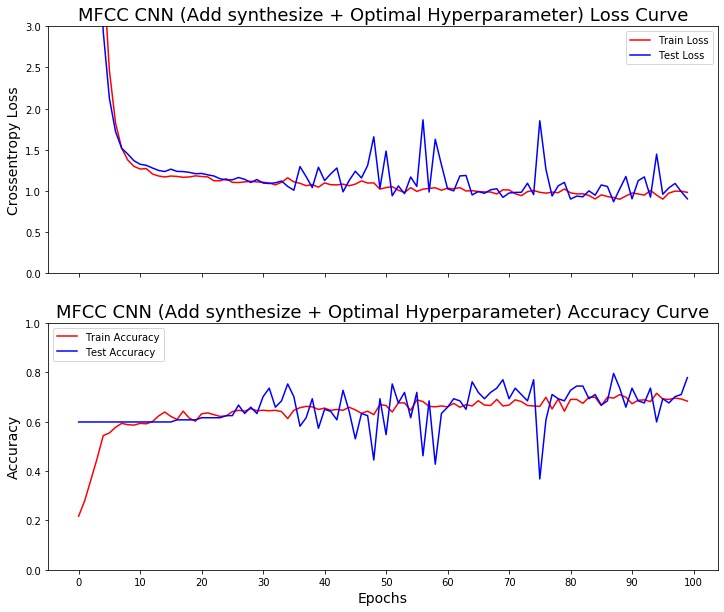

In [40]:
loss_acc_plot(history4, 100, 'MFCC CNN (Add synthesize + Optimal Hyperparameter)')

In [41]:
### X_test loss and accuracy score

xtest_loss_acc(model4, X_test, y_test)

cnn loss: 0.904
cnn accuracy: 0.778


### Prediction and Model Evaluation (synthesized audio)

Model with optimized hyperparameter resulted in:

- `Normal`, precision = 78% (model 3 = 75%).
- `Murmur`, precision = 83% (model 3 = 60%).
- `extrahls`, `extrastole` precision = 0% (worst than model3 = 0% & 14%, respectively)
- `Artifact`, precision 67% (model 3 = 78%).
- Overall accuracy increases to 78%. But it fails to predict the minority class.

In [43]:
yt_4,yp_4 = class_report(model4, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       0.67      1.00      0.80         8
    extrahls       0.00      0.00      0.00         4
  extrastole       0.00      0.00      0.00         9
      murmur       0.83      0.77      0.80        26
      normal       0.78      0.90      0.83        70

    accuracy                           0.78       117
   macro avg       0.46      0.53      0.49       117
weighted avg       0.70      0.78      0.73       117



### Confusion Matrix

[[ 8  0  0  0  0]
 [ 0  0  0  0  4]
 [ 0  0  0  0  9]
 [ 1  0  0 20  5]
 [ 3  0  0  4 63]]


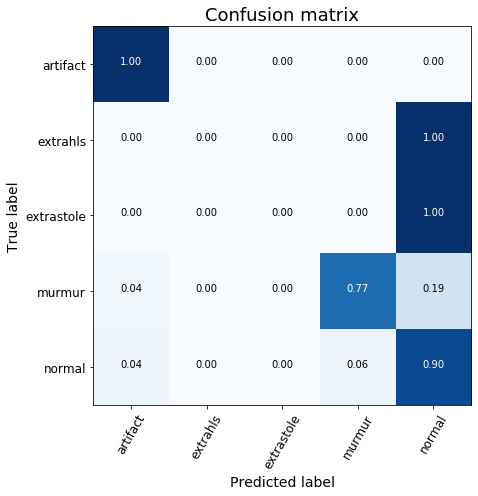

In [44]:
conf_matrix(yt_4, yp_4, le)

## 5.2.3 X_train (Synthesize audio + Oversampling)

In [45]:
### load the preprocessed data 

%store -r X_train 
%store -r X_test 
%store -r y_train 
%store -r y_test 
%store -r X_aunlabel
%store -r X_bunlabel
%store -r le
%store -r class_weights

In [46]:
X_train.shape

(854, 20, 130, 1)

### CNN using Optimal Hyperparameter obtain from previous section

In [47]:
### Build and Fit model
model5 = cnn_model(32, 3,(X_train.shape[1], X_train.shape[2], X_train.shape[3]) ,
                16, 2, 0.5,
                32, 3, 0.2,
                128, 0.2, 0.2,
               0.001)
    
history5 = model5.fit(X_train, y_train, validation_data = (X_test, y_test),
                     epochs = 100, class_weight=class_weights, shuffle = True, verbose =2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 20, 130, 32)       320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 65, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 65, 16)        2064      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 32, 16)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 32, 16)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 5, 32, 32)         4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 16, 32)        

Epoch 65/100
 - 2s - loss: 1.0734 - accuracy: 0.6206 - val_loss: 1.4362 - val_accuracy: 0.4957
Epoch 66/100
 - 2s - loss: 1.0524 - accuracy: 0.6311 - val_loss: 1.7647 - val_accuracy: 0.3675
Epoch 67/100
 - 2s - loss: 1.1115 - accuracy: 0.6066 - val_loss: 1.1837 - val_accuracy: 0.6410
Epoch 68/100
 - 2s - loss: 1.1058 - accuracy: 0.6042 - val_loss: 1.2988 - val_accuracy: 0.4872
Epoch 69/100
 - 2s - loss: 1.0492 - accuracy: 0.6311 - val_loss: 1.4282 - val_accuracy: 0.4701
Epoch 70/100
 - 2s - loss: 1.0147 - accuracy: 0.6569 - val_loss: 1.0832 - val_accuracy: 0.6581
Epoch 71/100
 - 2s - loss: 1.0423 - accuracy: 0.6241 - val_loss: 1.3758 - val_accuracy: 0.4786
Epoch 72/100
 - 2s - loss: 1.0752 - accuracy: 0.6311 - val_loss: 1.1524 - val_accuracy: 0.6667
Epoch 73/100
 - 2s - loss: 1.0139 - accuracy: 0.6464 - val_loss: 1.0567 - val_accuracy: 0.6752
Epoch 74/100
 - 2s - loss: 1.0603 - accuracy: 0.6206 - val_loss: 1.8580 - val_accuracy: 0.4188
Epoch 75/100
 - 2s - loss: 1.0679 - accuracy: 0.62

### Evaluate Loss and Accuracy
**X_train: Synthesize + Oversampling minority category**

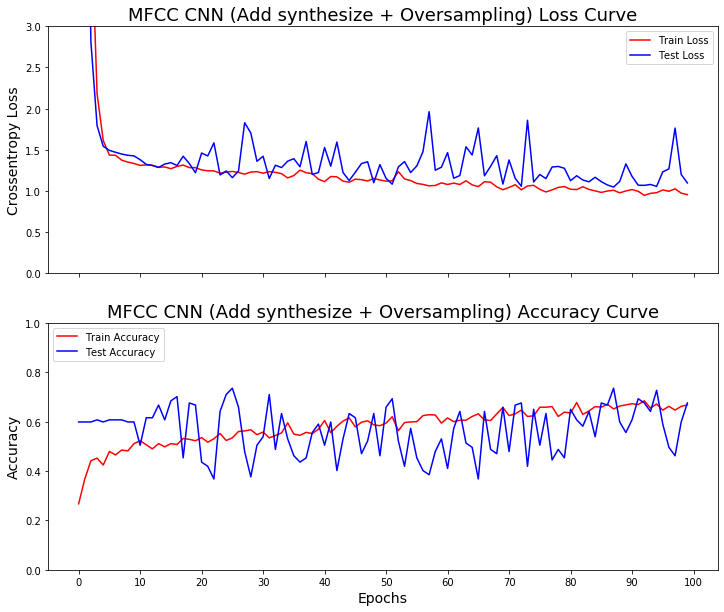

In [48]:
loss_acc_plot(history5, 100, 'MFCC CNN (Add synthesize + Oversampling)')

In [51]:
### X_test loss and accuracy score

xtest_loss_acc(model5, X_test, y_test)

cnn loss: 1.097
cnn accuracy: 0.675


### Prediction and Model Evaluation (synthesize audio + oversampling minority category)

- `Normal`, precision = 78% (model 4 = 78%).
- `Murmur`, precision = 72% (worst than model 4 = 83%).
- `extrahls`, `extrastole` precision = 14%, 15% (worst than model3 = 0%, respectively)
- `Artifact`, precision 100% (model 4 = 67%).

By treating the imbalanced class using synthesize audio plus oversampling, the model using the model4 hyperparameter seems able to classify minority class, but with low precision score.

In [50]:
yt_5,yp_5 = class_report(model5, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       1.00      0.88      0.93         8
    extrahls       0.14      0.25      0.18         4
  extrastole       0.15      0.22      0.18         9
      murmur       0.72      0.69      0.71        26
      normal       0.78      0.73      0.76        70

    accuracy                           0.68       117
   macro avg       0.56      0.55      0.55       117
weighted avg       0.71      0.68      0.69       117



### Confusion Matrix

[[ 7  0  0  1  0]
 [ 0  1  0  1  2]
 [ 0  0  2  0  7]
 [ 0  2  1 18  5]
 [ 0  4 10  5 51]]


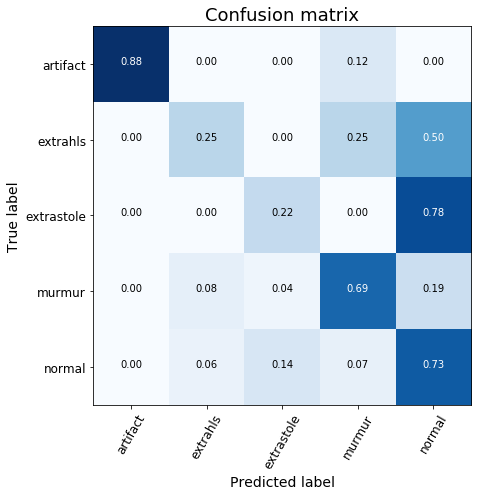

In [52]:
conf_matrix(yt_5, yp_5, le)

## 5.2.3.1 Hyperparameter Tuning with RandomSearchCV 
**X_train: with Synthesize audio + Oversampling on minority category**

In [53]:
### Instantiate user defined function and run RandomizedSearchCV
input_shapes = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

nn = KerasClassifier(build_fn = model_funcs, epochs = 50, verbose = 2)

### Instantiate RandomSearchCV
rscv3 = RandomizedSearchCV(nn, param_distributions = params, cv = 3)
rscv3.fit(X_train, y_train)

# model best estimators
print(f"best estimator: {rscv3.best_params_}")
print(f"best score: {rscv3.best_score_}")

Epoch 1/50
 - 2s - loss: 16.5366 - accuracy: 0.3076
Epoch 2/50
 - 1s - loss: 8.1056 - accuracy: 0.3322
Epoch 3/50
 - 1s - loss: 7.4547 - accuracy: 0.3427
Epoch 4/50
 - 1s - loss: 6.0858 - accuracy: 0.4130
Epoch 5/50
 - 1s - loss: 5.9092 - accuracy: 0.3849
Epoch 6/50
 - 1s - loss: 6.2534 - accuracy: 0.3937
Epoch 7/50
 - 1s - loss: 5.5715 - accuracy: 0.3796
Epoch 8/50
 - 2s - loss: 4.7154 - accuracy: 0.4411
Epoch 9/50
 - 2s - loss: 4.3574 - accuracy: 0.4183
Epoch 10/50
 - 1s - loss: 5.4715 - accuracy: 0.4411
Epoch 11/50
 - 1s - loss: 4.4592 - accuracy: 0.4341
Epoch 12/50
 - 2s - loss: 4.7525 - accuracy: 0.4060
Epoch 13/50
 - 1s - loss: 4.5942 - accuracy: 0.4112
Epoch 14/50
 - 1s - loss: 4.3814 - accuracy: 0.4253
Epoch 15/50
 - 2s - loss: 4.0044 - accuracy: 0.4077
Epoch 16/50
 - 2s - loss: 4.0771 - accuracy: 0.4218
Epoch 17/50
 - 1s - loss: 5.3103 - accuracy: 0.3972
Epoch 18/50
 - 1s - loss: 4.2504 - accuracy: 0.4552
Epoch 19/50
 - 2s - loss: 3.4817 - accuracy: 0.4499
Epoch 20/50
 - 2s - 

 - 3s - loss: 2.7637 - accuracy: 0.4763
Epoch 10/50
 - 3s - loss: 2.3668 - accuracy: 0.4763
Epoch 11/50
 - 3s - loss: 2.5362 - accuracy: 0.4359
Epoch 12/50
 - 2s - loss: 2.3272 - accuracy: 0.4587
Epoch 13/50
 - 2s - loss: 2.3616 - accuracy: 0.4482
Epoch 14/50
 - 2s - loss: 2.4723 - accuracy: 0.4728
Epoch 15/50
 - 2s - loss: 2.2381 - accuracy: 0.4692
Epoch 16/50
 - 2s - loss: 1.9573 - accuracy: 0.5149
Epoch 17/50
 - 2s - loss: 2.1024 - accuracy: 0.4938
Epoch 18/50
 - 2s - loss: 1.9747 - accuracy: 0.4728
Epoch 19/50
 - 2s - loss: 2.0442 - accuracy: 0.5009
Epoch 20/50
 - 2s - loss: 2.0140 - accuracy: 0.5167
Epoch 21/50
 - 2s - loss: 1.9734 - accuracy: 0.5026
Epoch 22/50
 - 2s - loss: 2.2541 - accuracy: 0.5044
Epoch 23/50
 - 2s - loss: 2.0951 - accuracy: 0.5185
Epoch 24/50
 - 2s - loss: 1.8201 - accuracy: 0.5466
Epoch 25/50
 - 2s - loss: 1.7781 - accuracy: 0.4921
Epoch 26/50
 - 2s - loss: 1.8542 - accuracy: 0.5255
Epoch 27/50
 - 2s - loss: 1.8063 - accuracy: 0.5395
Epoch 28/50
 - 2s - loss

Epoch 18/50
 - 1s - loss: 3.9395 - accuracy: 0.4306
Epoch 19/50
 - 1s - loss: 4.0252 - accuracy: 0.4692
Epoch 20/50
 - 1s - loss: 3.5024 - accuracy: 0.4974
Epoch 21/50
 - 1s - loss: 2.8451 - accuracy: 0.4095
Epoch 22/50
 - 1s - loss: 4.0552 - accuracy: 0.4077
Epoch 23/50
 - 1s - loss: 5.7068 - accuracy: 0.4236
Epoch 24/50
 - 1s - loss: 4.3208 - accuracy: 0.4728
Epoch 25/50
 - 1s - loss: 3.9793 - accuracy: 0.4552
Epoch 26/50
 - 1s - loss: 3.2561 - accuracy: 0.4306
Epoch 27/50
 - 1s - loss: 4.0838 - accuracy: 0.4728
Epoch 28/50
 - 1s - loss: 4.0439 - accuracy: 0.4587
Epoch 29/50
 - 1s - loss: 3.6281 - accuracy: 0.4640
Epoch 30/50
 - 1s - loss: 3.4390 - accuracy: 0.4833
Epoch 31/50
 - 1s - loss: 3.2316 - accuracy: 0.4429
Epoch 32/50
 - 1s - loss: 3.6796 - accuracy: 0.5044
Epoch 33/50
 - 1s - loss: 3.0716 - accuracy: 0.4464
Epoch 34/50
 - 1s - loss: 3.1948 - accuracy: 0.4763
Epoch 35/50
 - 1s - loss: 3.2606 - accuracy: 0.4640
Epoch 36/50
 - 1s - loss: 3.3258 - accuracy: 0.4851
Epoch 37/50


 - 2s - loss: 1.1891 - accuracy: 0.6134
Epoch 27/50
 - 2s - loss: 1.1261 - accuracy: 0.6485
Epoch 28/50
 - 2s - loss: 1.1579 - accuracy: 0.6169
Epoch 29/50
 - 2s - loss: 1.0759 - accuracy: 0.6766
Epoch 30/50
 - 2s - loss: 1.0787 - accuracy: 0.6538
Epoch 31/50
 - 2s - loss: 1.0872 - accuracy: 0.6696
Epoch 32/50
 - 2s - loss: 1.0764 - accuracy: 0.6696
Epoch 33/50
 - 2s - loss: 1.0497 - accuracy: 0.6591
Epoch 34/50
 - 2s - loss: 1.0493 - accuracy: 0.6661
Epoch 35/50
 - 2s - loss: 1.0381 - accuracy: 0.6538
Epoch 36/50
 - 2s - loss: 1.0175 - accuracy: 0.6643
Epoch 37/50
 - 2s - loss: 0.9733 - accuracy: 0.7170
Epoch 38/50
 - 2s - loss: 0.9274 - accuracy: 0.6977
Epoch 39/50
 - 2s - loss: 0.9511 - accuracy: 0.6819
Epoch 40/50
 - 2s - loss: 0.9109 - accuracy: 0.7276
Epoch 41/50
 - 2s - loss: 0.9070 - accuracy: 0.7118
Epoch 42/50
 - 2s - loss: 0.9693 - accuracy: 0.7030
Epoch 43/50
 - 2s - loss: 0.9267 - accuracy: 0.7311
Epoch 44/50
 - 2s - loss: 0.9099 - accuracy: 0.7364
Epoch 45/50
 - 2s - loss

 - 2s - loss: 4.3091 - accuracy: 0.5712
Epoch 35/50
 - 2s - loss: 4.1740 - accuracy: 0.5606
Epoch 36/50
 - 2s - loss: 4.0338 - accuracy: 0.5852
Epoch 37/50
 - 2s - loss: 3.9299 - accuracy: 0.5835
Epoch 38/50
 - 2s - loss: 3.8024 - accuracy: 0.5800
Epoch 39/50
 - 2s - loss: 3.6818 - accuracy: 0.5817
Epoch 40/50
 - 2s - loss: 3.5817 - accuracy: 0.6046
Epoch 41/50
 - 2s - loss: 3.4814 - accuracy: 0.5975
Epoch 42/50
 - 2s - loss: 3.3754 - accuracy: 0.6221
Epoch 43/50
 - 2s - loss: 3.2917 - accuracy: 0.5993
Epoch 44/50
 - 2s - loss: 3.1750 - accuracy: 0.6257
Epoch 45/50
 - 2s - loss: 3.0897 - accuracy: 0.6257
Epoch 46/50
 - 2s - loss: 3.0157 - accuracy: 0.6221
Epoch 47/50
 - 2s - loss: 2.9199 - accuracy: 0.6292
Epoch 48/50
 - 2s - loss: 2.8345 - accuracy: 0.6274
Epoch 49/50
 - 2s - loss: 2.7552 - accuracy: 0.6274
Epoch 50/50
 - 2s - loss: 2.6667 - accuracy: 0.6432
Epoch 1/50
 - 3s - loss: 13.8786 - accuracy: 0.2302
Epoch 2/50
 - 2s - loss: 13.3052 - accuracy: 0.2583
Epoch 3/50
 - 2s - loss:

Epoch 42/50
 - 1s - loss: 0.9338 - accuracy: 0.6854
Epoch 43/50
 - 1s - loss: 0.9257 - accuracy: 0.6643
Epoch 44/50
 - 2s - loss: 0.9112 - accuracy: 0.7135
Epoch 45/50
 - 2s - loss: 0.9042 - accuracy: 0.6801
Epoch 46/50
 - 2s - loss: 0.8460 - accuracy: 0.7188
Epoch 47/50
 - 2s - loss: 0.8807 - accuracy: 0.6977
Epoch 48/50
 - 2s - loss: 0.8767 - accuracy: 0.6872
Epoch 49/50
 - 2s - loss: 0.8064 - accuracy: 0.7381
Epoch 50/50
 - 1s - loss: 0.8453 - accuracy: 0.7153
Epoch 1/50
 - 4s - loss: 4.3575 - accuracy: 0.2320
Epoch 2/50
 - 2s - loss: 3.8849 - accuracy: 0.2830
Epoch 3/50
 - 2s - loss: 3.7511 - accuracy: 0.2900
Epoch 4/50
 - 2s - loss: 3.3945 - accuracy: 0.3286
Epoch 5/50
 - 2s - loss: 3.2491 - accuracy: 0.3585
Epoch 6/50
 - 2s - loss: 3.1207 - accuracy: 0.3409
Epoch 7/50
 - 2s - loss: 2.8288 - accuracy: 0.4288
Epoch 8/50
 - 2s - loss: 2.6841 - accuracy: 0.4429
Epoch 9/50
 - 2s - loss: 2.6009 - accuracy: 0.4236
Epoch 10/50
 - 2s - loss: 2.4283 - accuracy: 0.4728
Epoch 11/50
 - 2s - l

 - 2s - loss: 0.9918 - accuracy: 0.6819
Epoch 1/50
 - 5s - loss: 7.7429 - accuracy: 0.2355
Epoch 2/50
 - 2s - loss: 6.0848 - accuracy: 0.2707
Epoch 3/50
 - 2s - loss: 5.1628 - accuracy: 0.2759
Epoch 4/50
 - 2s - loss: 4.3896 - accuracy: 0.2953
Epoch 5/50
 - 2s - loss: 3.7823 - accuracy: 0.3550
Epoch 6/50
 - 2s - loss: 3.2883 - accuracy: 0.3954
Epoch 7/50
 - 2s - loss: 2.9005 - accuracy: 0.4112
Epoch 8/50
 - 2s - loss: 2.6235 - accuracy: 0.4517
Epoch 9/50
 - 2s - loss: 2.4435 - accuracy: 0.4745
Epoch 10/50
 - 2s - loss: 2.2601 - accuracy: 0.4482
Epoch 11/50
 - 2s - loss: 2.1429 - accuracy: 0.4446
Epoch 12/50
 - 2s - loss: 1.9493 - accuracy: 0.4728
Epoch 13/50
 - 3s - loss: 1.8713 - accuracy: 0.4710
Epoch 14/50
 - 2s - loss: 1.7437 - accuracy: 0.4903
Epoch 15/50
 - 2s - loss: 1.6505 - accuracy: 0.5308
Epoch 16/50
 - 2s - loss: 1.5734 - accuracy: 0.5290
Epoch 17/50
 - 2s - loss: 1.5481 - accuracy: 0.5308
Epoch 18/50
 - 2s - loss: 1.5372 - accuracy: 0.4938
Epoch 19/50
 - 2s - loss: 1.4306 

Epoch 9/50
 - 2s - loss: 3.5064 - accuracy: 0.4112
Epoch 10/50
 - 2s - loss: 3.3923 - accuracy: 0.4183
Epoch 11/50
 - 2s - loss: 3.5984 - accuracy: 0.4077
Epoch 12/50
 - 2s - loss: 3.1795 - accuracy: 0.4886
Epoch 13/50
 - 2s - loss: 2.8247 - accuracy: 0.4587
Epoch 14/50
 - 2s - loss: 2.6885 - accuracy: 0.4938
Epoch 15/50
 - 2s - loss: 2.7531 - accuracy: 0.4482
Epoch 16/50
 - 2s - loss: 2.8888 - accuracy: 0.4411
Epoch 17/50
 - 2s - loss: 2.6168 - accuracy: 0.4886
Epoch 18/50
 - 2s - loss: 2.2776 - accuracy: 0.4903
Epoch 19/50
 - 2s - loss: 2.3950 - accuracy: 0.5044
Epoch 20/50
 - 2s - loss: 2.0938 - accuracy: 0.5202
Epoch 21/50
 - 2s - loss: 2.1243 - accuracy: 0.5290
Epoch 22/50
 - 2s - loss: 2.2952 - accuracy: 0.4798
Epoch 23/50
 - 2s - loss: 2.5905 - accuracy: 0.5079
Epoch 24/50
 - 2s - loss: 2.2358 - accuracy: 0.5079
Epoch 25/50
 - 2s - loss: 2.1774 - accuracy: 0.5202
Epoch 26/50
 - 2s - loss: 2.0990 - accuracy: 0.5237
Epoch 27/50
 - 2s - loss: 1.9755 - accuracy: 0.5220
Epoch 28/50
 

 - 1s - loss: 1.6015 - accuracy: 0.4552
Epoch 18/50
 - 2s - loss: 1.5364 - accuracy: 0.4323
Epoch 19/50
 - 1s - loss: 1.5699 - accuracy: 0.4359
Epoch 20/50
 - 1s - loss: 1.5555 - accuracy: 0.4499
Epoch 21/50
 - 1s - loss: 1.5250 - accuracy: 0.4745
Epoch 22/50
 - 2s - loss: 1.5390 - accuracy: 0.4692
Epoch 23/50
 - 1s - loss: 1.5133 - accuracy: 0.4798
Epoch 24/50
 - 1s - loss: 1.6108 - accuracy: 0.4288
Epoch 25/50
 - 1s - loss: 1.6301 - accuracy: 0.4482
Epoch 26/50
 - 1s - loss: 1.5998 - accuracy: 0.4429
Epoch 27/50
 - 1s - loss: 1.4200 - accuracy: 0.4833
Epoch 28/50
 - 1s - loss: 1.4579 - accuracy: 0.4534
Epoch 29/50
 - 2s - loss: 1.4184 - accuracy: 0.4991
Epoch 30/50
 - 1s - loss: 1.3918 - accuracy: 0.5044
Epoch 31/50
 - 1s - loss: 1.4646 - accuracy: 0.4710
Epoch 32/50
 - 1s - loss: 1.4212 - accuracy: 0.4763
Epoch 33/50
 - 1s - loss: 1.3746 - accuracy: 0.4921
Epoch 34/50
 - 1s - loss: 1.4376 - accuracy: 0.4956
Epoch 35/50
 - 1s - loss: 1.4418 - accuracy: 0.5062
Epoch 36/50
 - 2s - loss

Epoch 26/50
 - 1s - loss: 1.2850 - accuracy: 0.5536
Epoch 27/50
 - 1s - loss: 1.2453 - accuracy: 0.5624
Epoch 28/50
 - 1s - loss: 1.2535 - accuracy: 0.5606
Epoch 29/50
 - 1s - loss: 1.2226 - accuracy: 0.5659
Epoch 30/50
 - 1s - loss: 1.2334 - accuracy: 0.5448
Epoch 31/50
 - 1s - loss: 1.1946 - accuracy: 0.5659
Epoch 32/50
 - 1s - loss: 1.1870 - accuracy: 0.5554
Epoch 33/50
 - 1s - loss: 1.1958 - accuracy: 0.5501
Epoch 34/50
 - 1s - loss: 1.1692 - accuracy: 0.5800
Epoch 35/50
 - 1s - loss: 1.1688 - accuracy: 0.5712
Epoch 36/50
 - 1s - loss: 1.1603 - accuracy: 0.5712
Epoch 37/50
 - 1s - loss: 1.1333 - accuracy: 0.5923
Epoch 38/50
 - 1s - loss: 1.1580 - accuracy: 0.5747
Epoch 39/50
 - 1s - loss: 1.1414 - accuracy: 0.6011
Epoch 40/50
 - 1s - loss: 1.1437 - accuracy: 0.5958
Epoch 41/50
 - 1s - loss: 1.1349 - accuracy: 0.6081
Epoch 42/50
 - 1s - loss: 1.1939 - accuracy: 0.5764
Epoch 43/50
 - 1s - loss: 1.1312 - accuracy: 0.5940
Epoch 44/50
 - 1s - loss: 1.1371 - accuracy: 0.6151
Epoch 45/50


In [54]:
### RandomizedSearchCV results

print(f" train score: {round(rscv3.best_score_, 4)}")
print(f" test score: {round(rscv3.score(X_test, y_test), 4)}")
print(f" best_parameters rscv3: {rscv3.best_params_}")

 train score: 0.7178
 test score: 0.547
 best_parameters rscv3: {'regularizer_rate': 0.01, 'opt_learning_rate': 0.001, 'neurons': 256, 'kernel_size_two': 5, 'kernel_size_three': 3, 'kernel_size_one': 2, 'filter_two': 32, 'filter_three': 128, 'filter_one': 16, 'dropout_two': 0.2, 'dropout_three': 0.2, 'dropout_four': 0.5}


## 5.2.2.2 CNN6 with Optimal Hyperparameter
**X_train: with Synthesize + Oversampling minority category**

In [55]:
### Fit model
model6 = cnn_model(16, 2,(X_train.shape[1], X_train.shape[2], X_train.shape[3]) ,
                32, 5, 0.2,
                128, 3, 0.2,
                256, 0.5, 0.01,
                0.001)
    
history6 = model6.fit(X_train, y_train, validation_data = (X_test, y_test),
                     epochs = 100, class_weight=class_weights, shuffle = True, verbose =2)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 20, 130, 16)       80        
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 10, 65, 16)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 10, 65, 32)        12832     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 5, 32, 32)         0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 5, 32, 32)         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 5, 32, 128)        36992     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 2, 16, 128)      

Epoch 65/100
 - 5s - loss: 0.5934 - accuracy: 0.8864 - val_loss: 1.4641 - val_accuracy: 0.6154
Epoch 66/100
 - 4s - loss: 0.5949 - accuracy: 0.8923 - val_loss: 1.5267 - val_accuracy: 0.5983
Epoch 67/100
 - 4s - loss: 0.5548 - accuracy: 0.9052 - val_loss: 1.3438 - val_accuracy: 0.6838
Epoch 68/100
 - 4s - loss: 0.5533 - accuracy: 0.9122 - val_loss: 1.2016 - val_accuracy: 0.7350
Epoch 69/100
 - 4s - loss: 0.5801 - accuracy: 0.8923 - val_loss: 1.5158 - val_accuracy: 0.6581
Epoch 70/100
 - 4s - loss: 0.5696 - accuracy: 0.9040 - val_loss: 1.3950 - val_accuracy: 0.6325
Epoch 71/100
 - 4s - loss: 0.5763 - accuracy: 0.8970 - val_loss: 1.9156 - val_accuracy: 0.5470
Epoch 72/100
 - 4s - loss: 0.5799 - accuracy: 0.9122 - val_loss: 1.4909 - val_accuracy: 0.6410
Epoch 73/100
 - 4s - loss: 0.5629 - accuracy: 0.9075 - val_loss: 1.9252 - val_accuracy: 0.5128
Epoch 74/100
 - 3s - loss: 0.5261 - accuracy: 0.9239 - val_loss: 1.5761 - val_accuracy: 0.6154
Epoch 75/100
 - 4s - loss: 0.5618 - accuracy: 0.89

### Evaluate Loss and Accuracy
**X_train: Synthesize + Oversampling minority category**

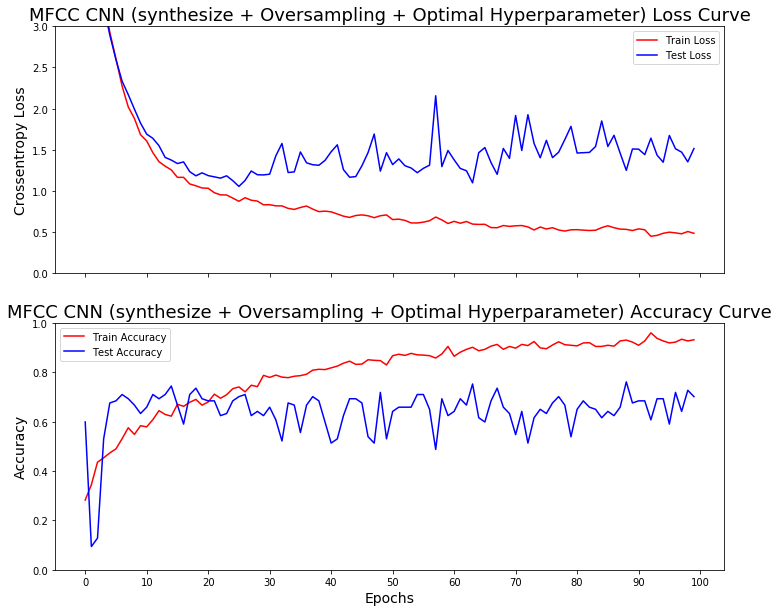

In [56]:
loss_acc_plot(history6, 100, 'MFCC CNN (synthesize + Oversampling + Optimal Hyperparameter)')

In [57]:
### X_test loss and accuracy score

xtest_loss_acc(model6, X_test, y_test)

cnn loss: 1.514
cnn accuracy: 0.701


### Prediction and Model Evaluation (synthesize audio + oversampling)

Model with optimized hyperparameter resulted in:

- `Normal`, precision = 78% (model 3=5 = 78%).
- `Murmur`, precision = 81% (model 5 = 72%).
- `extrahls`, `extrastole` precision = 25%, 17%(better than model5 = 14% & 15%, respectively)
- `Artifact`, precision 50% (worst than model 5 = 100%).
- Overall accuracy = 70%, compared to model5 68%. 

Using the optimized hyperparameter, the model improved in classifying the minority class.

In [59]:
yt_6,yp_6 = class_report(model6, X_test, y_test, le)

              precision    recall  f1-score   support

    artifact       0.50      0.88      0.64         8
    extrahls       0.25      0.25      0.25         4
  extrastole       0.17      0.11      0.13         9
      murmur       0.81      0.65      0.72        26
      normal       0.78      0.80      0.79        70

    accuracy                           0.70       117
   macro avg       0.50      0.54      0.51       117
weighted avg       0.70      0.70      0.69       117



### Confusion Matrix

[[ 7  0  0  1  0]
 [ 0  1  0  1  2]
 [ 0  0  1  0  8]
 [ 2  0  1 17  6]
 [ 5  3  4  2 56]]


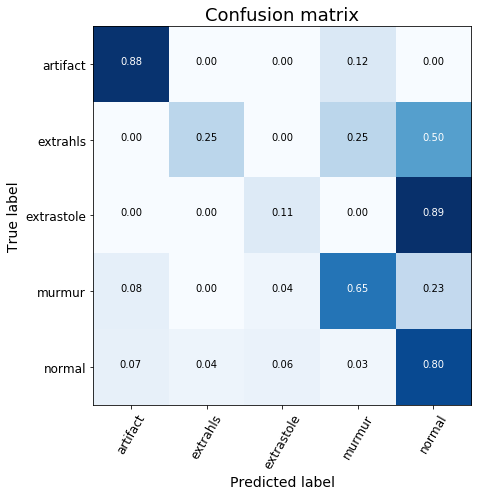

In [60]:
conf_matrix(yt_6, yp_6, le)

## 5.2.4 Predict Unlabel data from Kaggle
**For all 6 cnn models**

In [64]:
### Predict unlabel audio and export results to csv file

model_list = [model, model2, model3, model4, model5, model6]
seta_col = ['normal', 'murmur', 'extrahls', 'artifact']   # col list from kaggle's evaluation_sheet
setb_col = ['normal', 'murmur', 'extrastole']
classes = le.classes_

for i in range(6):
    pred_a = model_list[i].predict_classes(X_aunlabel)
    pred_b = model_list[i].predict_classes(X_bunlabel)
    
    ### to dummies
    pred_a = to_categorical(pred_a)
    pred_b = to_categorical(pred_b)
    
    ### to df
    pred_a_df = pd.DataFrame(pred_a.astype(int), columns= classes)
    pred_a_df = pred_a_df[seta_col]
    pred_b_df = pd.DataFrame(pred_b.astype(int), columns= classes)
    pred_b_df = pred_b_df[setb_col]
    
    ### export to csv
    name_a = '../outputs/kaggle_eval/mfcc_seta' + str(i+1) + '.csv'
    name_b = '../outputs/kaggle_eval/mfcc_setb' + str(i+1) + '.csv'
    pred_a_df.to_csv(name_a, index = False)
    pred_b_df.to_csv(name_b, index = False)

## Results Compilation

This section compile all the modelling performance (notebook 3a, 3b, 3c) on:
1. X_test data
2. Unlabel data from set a & set b

In [66]:
### Modelling on Unlabel set a

col_name_a = ['precision_normal', 'precision_murmur', 'precision_extrahls', 
            'precision_artifact', 'total_precision', 'Youden Index of artifact', 
             'F-Score_heartproblem']
row_name = ['mfcc_cnn1', 'mfcc_cnn2', 'mfcc_cnn3', 'mfcc_cnn4', 'mfcc_cnn5', 'mfcc_cnn6',
            'cwt_cnn1', 'cwt_cnn2', 'cwt_cnn3','cwt_cnn4','cwt_cnn5','cwt_cnn6',
            'pca_xgb5', 'pca_xgb6']

model_mfcc1_a = [0.387, 0.429, 0.0, 1.0, 1.82, -0.063, 0.153]
model_mfcc2_a = [0.324, 0.0, 0.0, 0.77, 1.10, -0.07, 0.0]
model_mfcc3_a = [0.292, 0.4, 0.0, 1.0, 1.692, 0.049, 0.144]
model_mfcc4_a = [0.424, 0.556, 0.0, 1.0, 1.98, 0.153, 0.151]
model_mfcc5_a = [0.278, 0.462, 0.125, 1.0, 1.86, 0.021, 0.146]
model_mfcc6_a = [0.25, 0.25, 0.0, 0.76, 1.26, 0.007, 0.028]
model_cwt1_a = [0.444, 0.8, 0.556, 0.682, 2.48, 0.41, 0.286]
model_cwt2_a = [0.313, 0.8, 0.333, 0.556, 2.0, 0.215, 0.157]
model_cwt3_a = [0.4, 1.0, 0.6, 0.667, 2.67, 0.361, 0.237]
model_cwt4_a = [0.385, 0.75, 0.714, 0.625, 2.47, 0.299, 0.225]
model_cwt5_a = [0.429, 0.778, 0.4, 0.842, 2.45, 0.444, 0.252]
model_cwt6_a = [0.571, 0.857, 0.353, 0.889, 2.67, 0.444, 0.232]
model_xgb5_a = [0.417, 0.818, 0.385, 0.875, 2.49, 0.403, 0.271]
model_xgb6_a = [0.545, 0.91, 0.467, 0.867, 2.79, 0.451, 0.314]


In [67]:
### Modelling on Unlabel set b

col_name_b = ['precision_normal', 'precision_murmur','precision_extrastole', 
              'total_precision', 'Youden Index of heartproblem', 'Discriminant_power']

model_mfcc1_b = [0.782, 0.406, 0.0, 1.19, 0.154, 0.161]
model_mfcc2_b = [0.741, 0.857, 0.15, 1.75, 0.115, 0.178]
model_mfcc3_b = [0.709, 0.455, 0.074, 1.24, -0.013, -0.015]
model_mfcc4_b = [0.745, 0.5, 0.0, 1.25, 0.165, 0.238]
model_mfcc5_b = [0.714, 0.393, 0.13, 1.24, -0.1, -0.119]
model_mfcc6_b = [0.777, 0.667, 0.083, 1.53, 0.134, 0.191]
model_cwt1_b = [0.759, 0.442, 0.091, 1.29, 0.126, 0.153]
model_cwt2_b = [0.756, 0.824, 0.0, 1.58, 0.193, 0.457]
model_cwt3_b = [0.764, 0.684, 0.077, 1.53, 0.142, 0.259]
model_cwt4_b = [0.766, 0.682, 0.077, 1.52, 0.161, 0.263]
model_cwt5_b = [0.764, 0.545, 0.083, 1.39, 0.153, 0.203]
model_cwt6_b = [0.787, 0.6, 0.148, 1.53, 0.16, 0.188]
model_xgb5_b = [0.728, 0.428, 0.25, 1.41, 0.048, 0.08]
model_xgb6_b = [0.727, 0.41, 0.133, 1.27, 0.01, 0.016]


In [68]:
### Modelling on Label TEST set

col_name_ab = ['precision_normal', 'precision_murmur', 'precision_extrahls', 
            'precision_artifact','precision_extrastole', 'weighted_avg_precision',
             'f1_normal', 'f1_murmur', 'f1_extrahls', 
            'f1_artifact','f1_extrastole', 'weighted_avg_f1', 'accuracy']

model_mfcc1 = [0.78, 0.56, 0.0, 0.78, 0.5, 0.68, 0.79, 0.63, 0.0, 0.82, 0.18, 0.68, 0.71]
model_mfcc2 = [0.71, 0.75, 0.0, 0.7, 0.09, 0.64, 0.74, 0.57, 0.0, 0.78, 0.1, 0.63, 0.64]
model_mfcc3 = [0.75, 0.6, 0.0, 0.78, 0.14, 0.64, 0.75, 0.64, 0.0, 0.82, 0.12, 0.66, 0.68]
model_mfcc4 = [0.78, 0.83, 0.0, 0.67, 0.0, 0.7, 0.83, 0.8, 0.0, 0.8, 0.0, 0.73, 0.78]
model_mfcc5 = [0.78, 0.72, 0.14, 1.0, 0.15, 0.71, 0.76, 0.71, 0.18, 0.93, 0.18, 0.69, 0.68]
model_mfcc6 = [0.78, 0.81, 0.25, 0.5, 0.17, 0.7, 0.79, 0.72, 0.25, 0.64, 0.13, 0.69, 0.7]
model_cwt1 = [0.79, 0.70, 0.2, 0.73, 0.0, 0.69, 0.78, 0.72, 0.22, 0.84, 0.0, 0.69, 0.70]
model_cwt2 = [0.71, 1.0, 0.5, 0.64, 0.0, 0.71, 0.81, 0.63, 0.33, 0.74, 0.0, 0.69, 0.73]
model_cwt3 = [0.7, 0.9, 0.5, 0.67, 0.0, 0.68, 0.75, 0.5, 0.6, 0.8, 0.0, 0.64, 0.66]
model_cwt4 = [0.75, 0.88, 0.4, 0.64, 0.09, 0.71, 0.77, 0.7, 0.44, 0.74, 0.1, 0.69, 0.68]
model_cwt5 = [0.75, 0.71, 0.2, 0.5, 0.0, 0.65, 0.76, 0.5, 0.22, 0.67, 0.0, 0.62, 0.62]
model_cwt6 = [0.73, 0.8, 0.2, 0.62, 0.0, 0.67, 0.68, 0.7, 0.22, 0.76, 0.0, 0.62, 0.59]
model_xgb5 = [0.68, 0.40, 0.0, 0.58, 0.25, 0.55, 0.67, 0.35, 0.0, 0.7, 0.29, 0.55, 0.55]
model_xgb6 = [0.67, 0.32, 0.17, 0.58, 0.12, 0.52, 0.66, 0.29, 0.2, 0.7, 0.12, 0.52, 0.53]

### Convert all the modelling results into dataFrame

In [69]:
# compile results into list
model_results_a = [model_mfcc1_a,model_mfcc2_a, model_mfcc3_a, model_mfcc4_a,
                   model_mfcc5_a,model_mfcc6_a, model_cwt1_a, model_cwt2_a,
                   model_cwt3_a, model_cwt4_a,model_cwt5_a, model_cwt6_a,
                   model_xgb5_a, model_xgb6_a]

model_results_b = [model_mfcc1_b,model_mfcc2_b, model_mfcc3_b, model_mfcc4_b,
                   model_mfcc5_b,model_mfcc6_b, model_cwt1_b, model_cwt2_b,
                   model_cwt3_b, model_cwt4_b,model_cwt5_b, model_cwt6_b,
                   model_xgb5_b, model_xgb6_b]

model_results_xtest = [model_mfcc1,model_mfcc2, model_mfcc3, model_mfcc4,
                   model_mfcc5,model_mfcc6, model_cwt1, model_cwt2,
                   model_cwt3, model_cwt4,model_cwt5, model_cwt6,
                   model_xgb5, model_xgb6]


# convert results to dataframe
results_a_df = pd.DataFrame(model_results_a, columns = col_name_a)
results_b_df = pd.DataFrame(model_results_b, columns = col_name_b)
results_xtest_df = pd.DataFrame(model_results_xtest, columns = col_name_ab)

## add in model name
results_a_df['model'] = row_name
results_b_df['model'] = row_name
results_xtest_df['model'] = row_name

## re-order 'model' column
results_a_df = results_a_df[['model','precision_normal', 'precision_murmur', 'precision_extrahls', 
            'precision_artifact', 'total_precision', 'Youden Index of artifact', 
             'F-Score_heartproblem']]
results_b_df = results_b_df[['model', 'precision_normal', 'precision_murmur','precision_extrastole', 
              'total_precision', 'Youden Index of heartproblem', 'Discriminant_power']]
results_xtest_df = results_xtest_df[['model', 'precision_normal', 'precision_murmur', 'precision_extrahls', 
            'precision_artifact','precision_extrastole', 'weighted_avg_precision',
             'f1_normal', 'f1_murmur', 'f1_extrahls', 
            'f1_artifact','f1_extrastole', 'weighted_avg_f1', 'accuracy']]

## add dataset_col
results_a_df['dataset'] ='a'
results_b_df['dataset'] ='b'

### Export modelling results for evaluation in notebook 4

In [70]:
### Export to csv

results_a_df.to_csv('../outputs/results_a.csv', index = False)
results_b_df.to_csv('../outputs/results_b.csv', index = False)
results_xtest_df.to_csv('../outputs/results_xtest.csv', index = False)

#### Proceed to notebook 3b for CWT + CNN modelling & notebook 3c for PCA + XGBOOST modelling